# 1. Import Libraries

In [111]:
import pandas as pd
import numpy as np 
import os
from tabulate import tabulate
import time
import pickle
import textwrap

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'monospace'

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import joblib
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, euclidean

from xgboost import XGBClassifier

from scipy.stats import boxcox

from IPython.display import display

RANDOM_STATE = 42

# 2. Data Preparation

In [112]:
category_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
                      'Obesity_Type_III']
# Encode target classes 
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}

In [113]:
df = pd.read_csv("train.csv")
df.drop(columns='id', inplace=True)
df.shape


(20758, 17)

In [114]:
df_original = pd.read_csv("ObesityDataSet.csv")
df_original.shape

(2111, 17)

In [115]:
#concat 2 bộ data
df = pd.concat([df, df_original], ignore_index=True)
print(df.shape)
df

(22869, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
22865,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
22866,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
22867,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [116]:
#drop duplicate
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df

(22845, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22840,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
22841,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
22842,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
22843,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [117]:
display(df.duplicated().sum())

np.int64(0)

In [118]:
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [119]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000
mean,23.888513,1.700467,87.793761,2.443675,2.755837,2.027165,0.984585,0.620984
std,5.755338,0.087865,26.363367,0.533392,0.711185,0.608479,0.839728,0.602802
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,22.815416,1.700000,84.000000,2.393837,3.000000,2.000000,1.000000,0.582840
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.531984,1.600431,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [120]:
df.describe(include="object")

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,22845,22845,22845,22845,22845,22845,22845,22845,22845
unique,2,2,2,4,2,2,4,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,11457,18736,20826,19290,22556,22062,16446,18245,4370


In [121]:
numerical_cols = [col_name for col_name in df.columns if df[col_name].dtype in ['int64', 'float64']]
categorical_cols = [col_name for col_name in df.columns if df[col_name].dtype == 'object' and col_name != 'NObeyesdad']
print("Numerical Columns: ", numerical_cols)
print("Categorical Columns: ", categorical_cols)

Numerical Columns:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Columns:  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [122]:
unique_counts = df[categorical_cols].nunique()
unique_values = df[categorical_cols].apply(lambda x: x.unique())
#tao df moi chua unique value
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
Gender,2,"[Male, Female]"
family_history_with_overweight,2,"[yes, no]"
FAVC,2,"[yes, no]"
CAEC,4,"[Sometimes, Frequently, no, Always]"
SMOKE,2,"[no, yes]"
SCC,2,"[no, yes]"
CALC,4,"[Sometimes, no, Frequently, Always]"
MTRANS,5,"[Public_Transportation, Automobile, Walking, M..."


# 3. EDA


In [123]:
nobeyesdadVC = df.NObeyesdad.value_counts().reindex(category_order)
nobeyesdadVC

NObeyesdad
Insufficient_Weight    2790
Normal_Weight          3364
Overweight_Level_I     2703
Overweight_Level_II    2812
Obesity_Type_I         3261
Obesity_Type_II        3545
Obesity_Type_III       4370
Name: count, dtype: int64

#### Target class distribution

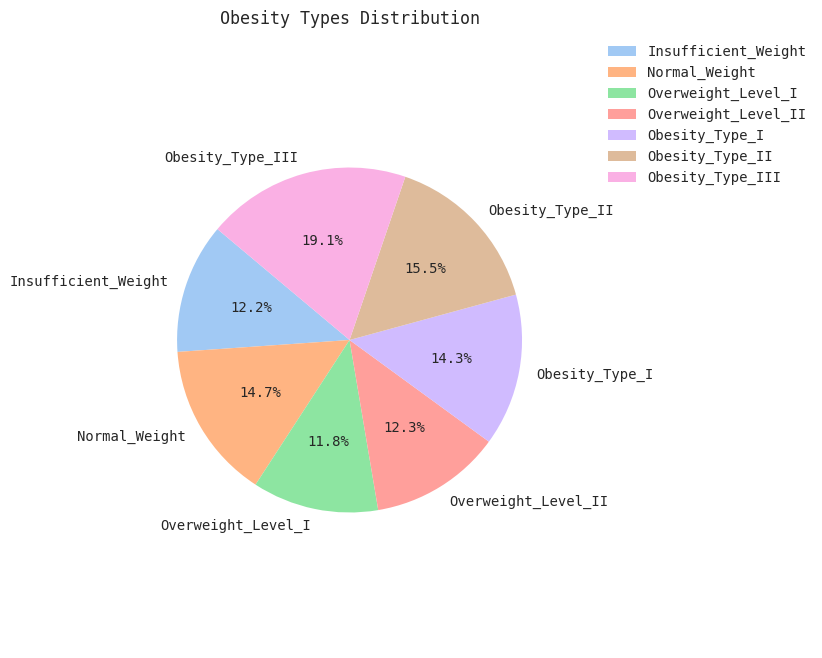

In [124]:
labels = nobeyesdadVC.index.tolist()
sizes = nobeyesdadVC.values.tolist()
colors = sns.color_palette('pastel')[0:10]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, radius=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.title('Obesity Types Distribution')

plt.show()

#### Distribution of categorical features

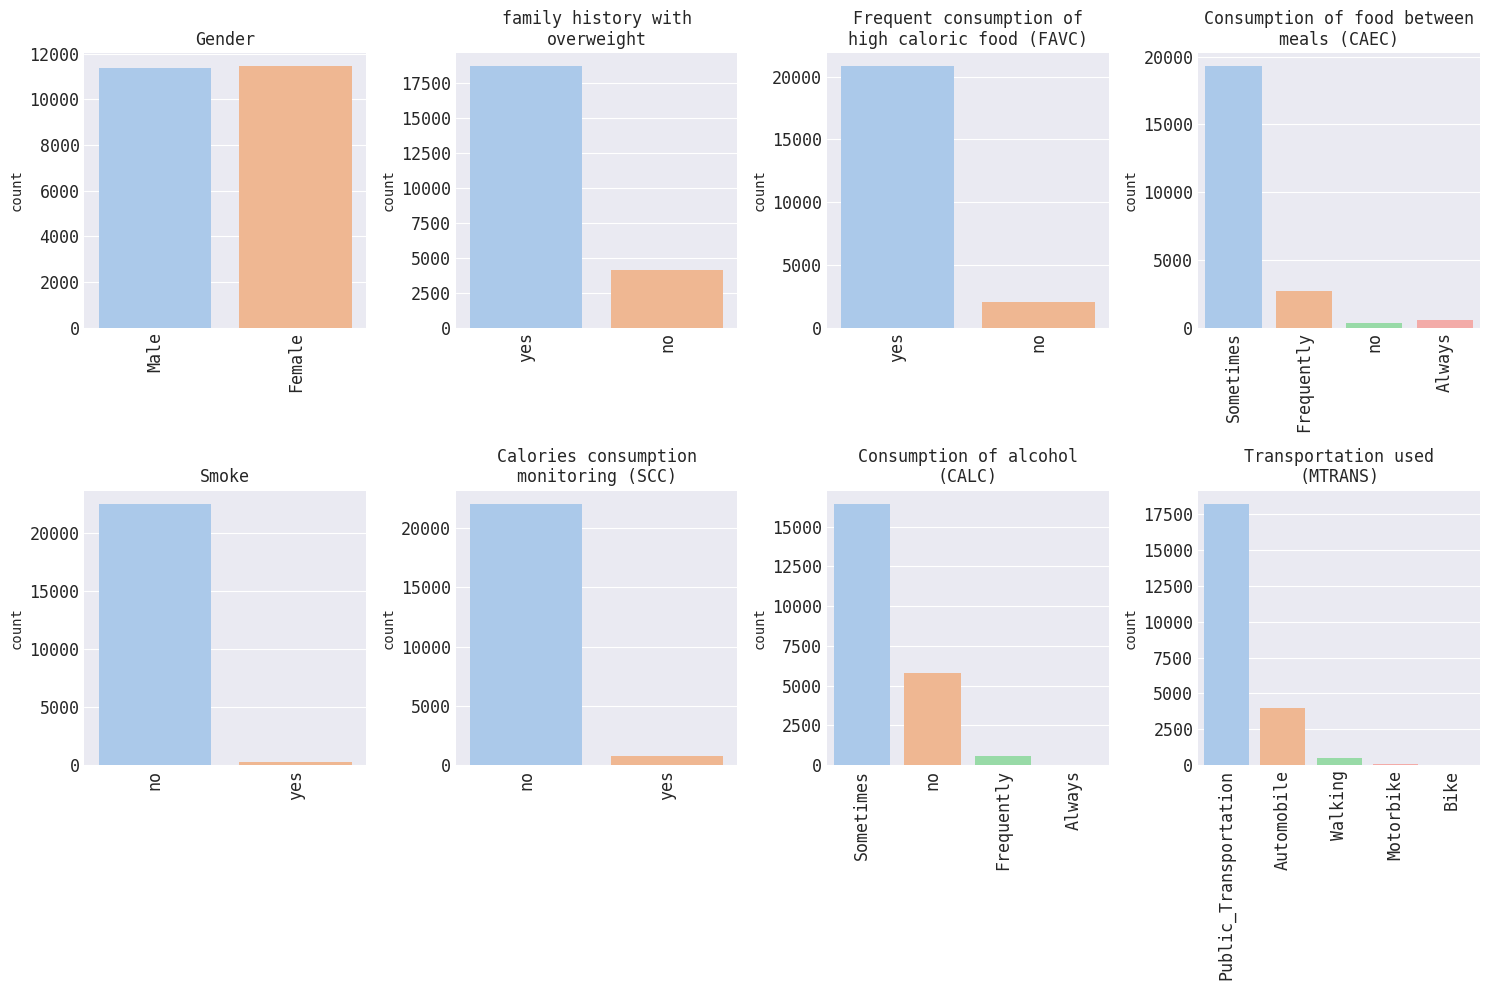

In [125]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

axes = axes.flatten()

num_columns_desc = ['Gender', 'family history with overweight', 'Frequent consumption of high caloric food (FAVC)', 'Consumption of food between meals (CAEC)', 'Smoke', 'Calories consumption monitoring (SCC)',
                'Consumption of alcohol (CALC)', 'Transportation used (MTRANS)']

for i, column in enumerate(df[categorical_cols].columns):
    sns.countplot(x=column, data=df, ax=axes[i], hue=column, palette='pastel')
    wrapped_title = '\n'.join(textwrap.wrap(f'{num_columns_desc[i]}', width=27))
    axes[i].set_title(wrapped_title)
    axes[i].title.set_size(12)
    axes[i].tick_params(axis='x', labelrotation=90)  
    axes[i].tick_params(axis='both', which='major', labelsize=12)  
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

#### Distribution of numerical features

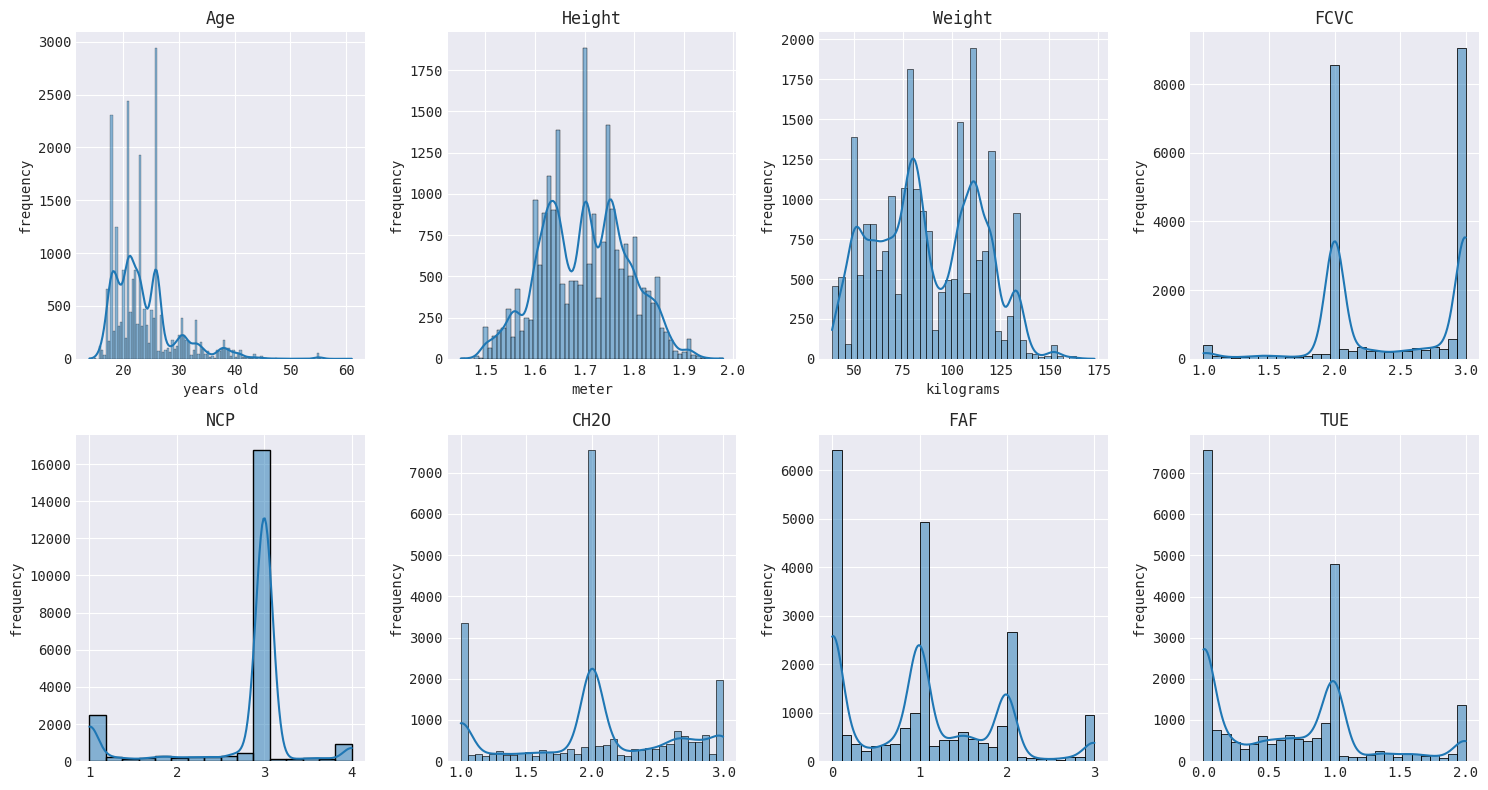

In [126]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 4*2))
axes = axes.flatten()

labels = ['years old', 'meter', 'kilograms', '', '', '','', '']

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, palette='pastel', kde=True, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].title.set_size(12)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel('frequency')
    
plt.tight_layout()
plt.show()

#### Outlier detection for numerical columns

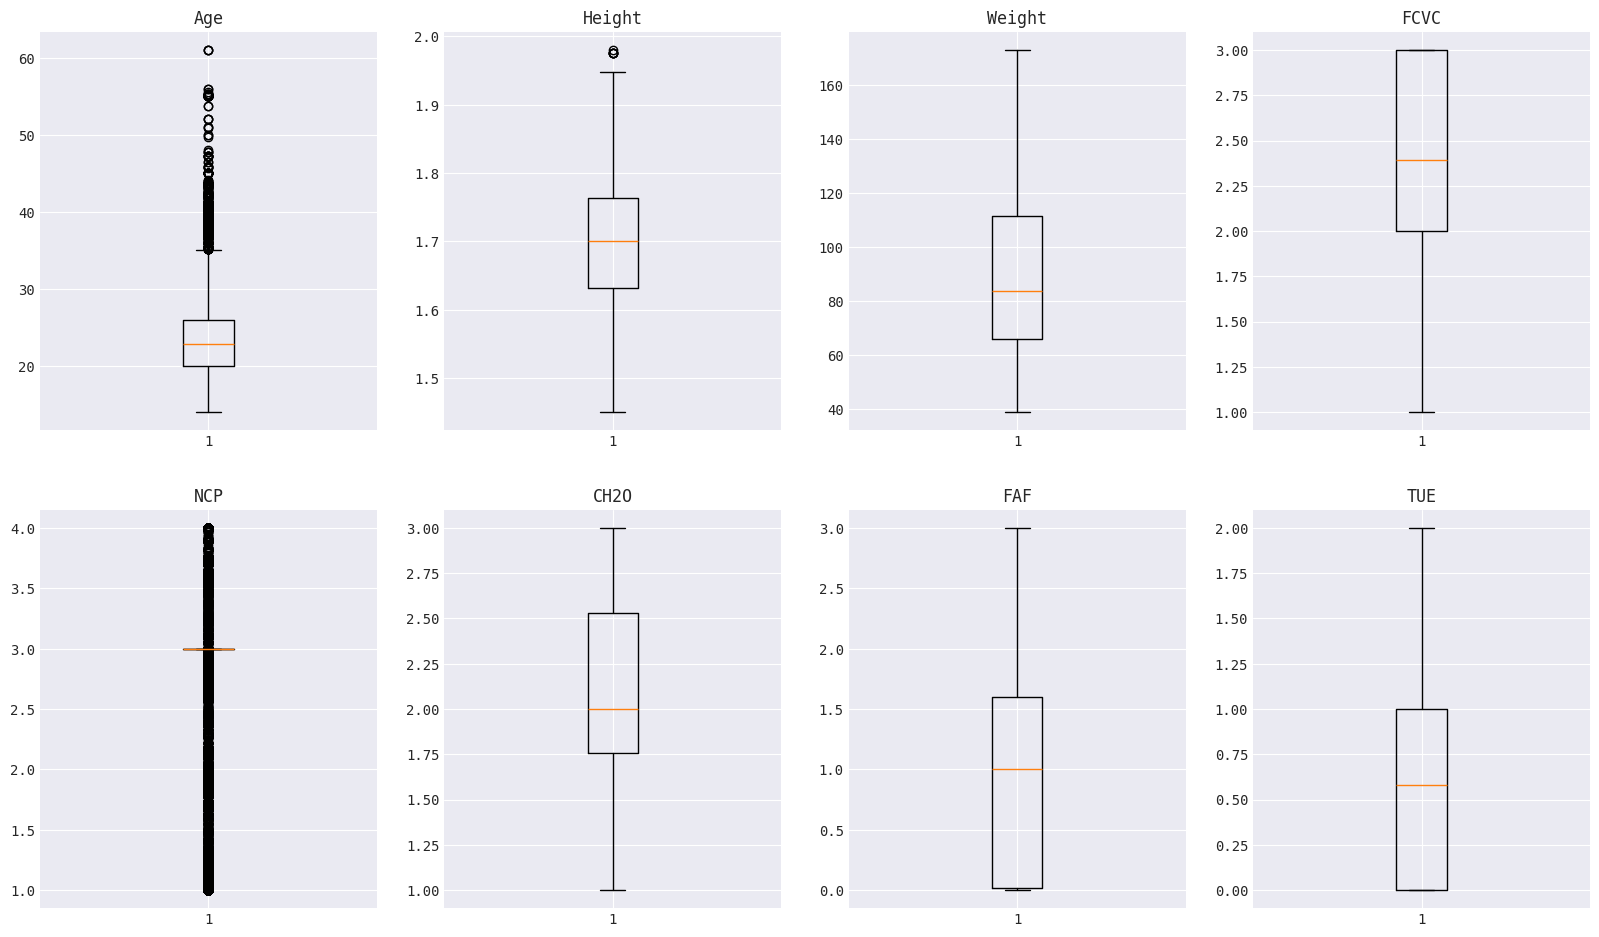

In [127]:
# Visualize the outliers using box plot
plt.figure(figsize=(20,30))
i = 1
columns_desc = ['Age', 'Height', 'Weight', 'Frequency of consumption of vegetables', 'Number of main meals', 'Consumption of water daily',
                'Physical activity frequency', 'Time using technology devices']
for col in numerical_cols:
    plt.subplot(5, 4, i)
    plt.boxplot(df[col], whis=1.5)
    plt.title(f'{col}')
    i += 1
plt.show()

#### Relationship between numerical features and target classes

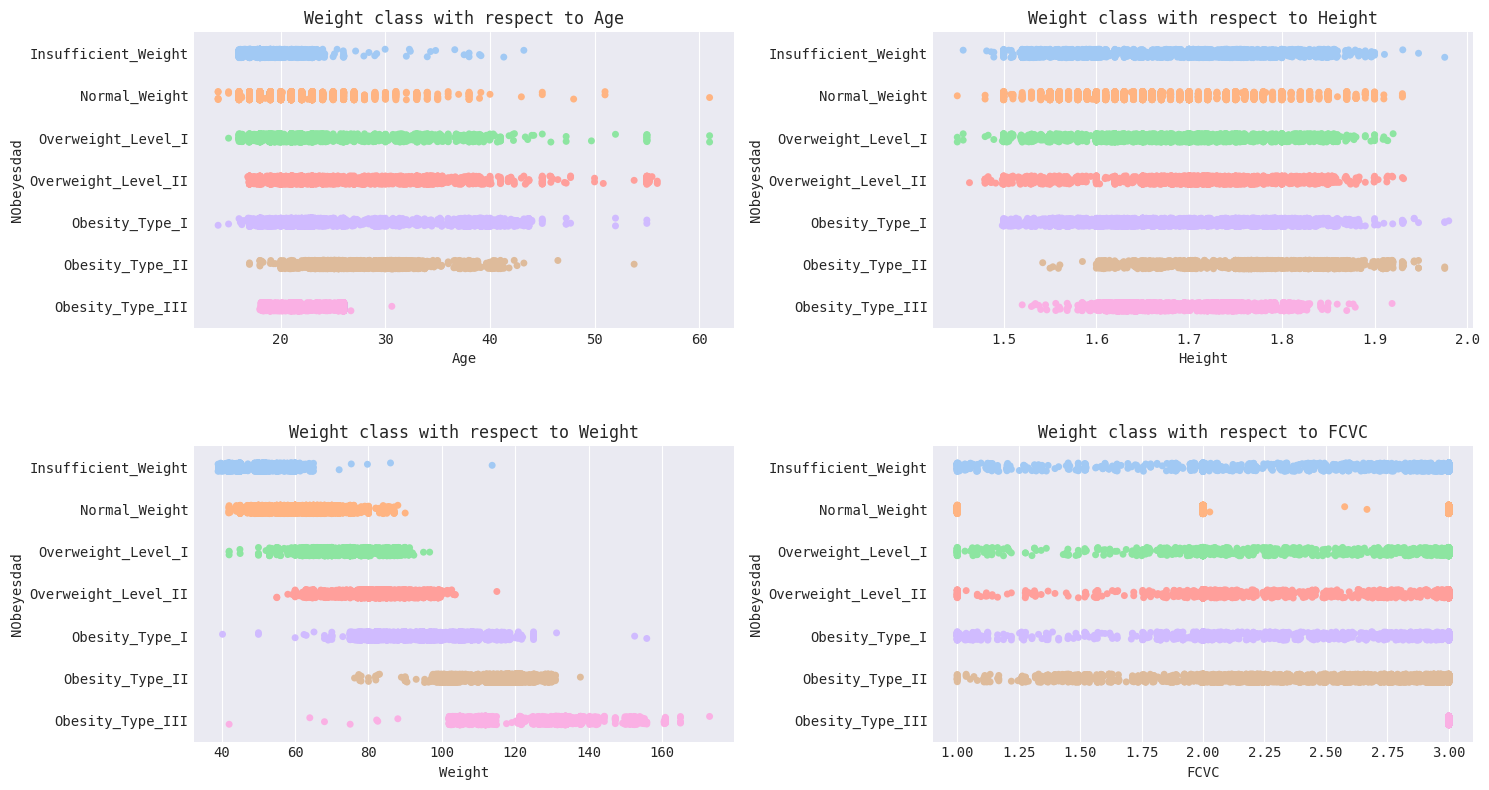

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(15, 4*2))
axes = axes.flatten()
sns.stripplot(data=df, ax=axes[0], x='Age', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[1], x='Height', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[2], x='Weight', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[3], x='FCVC', y='NObeyesdad', palette='pastel', order=category_order)

# Title for each subplots
axes[0].set_title('Weight class with respect to Age')
axes[1].set_title('Weight class with respect to Height')
axes[2].set_title('Weight class with respect to Weight')
axes[3].set_title('Weight class with respect to FCVC')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 

# Show the plot
plt.show()

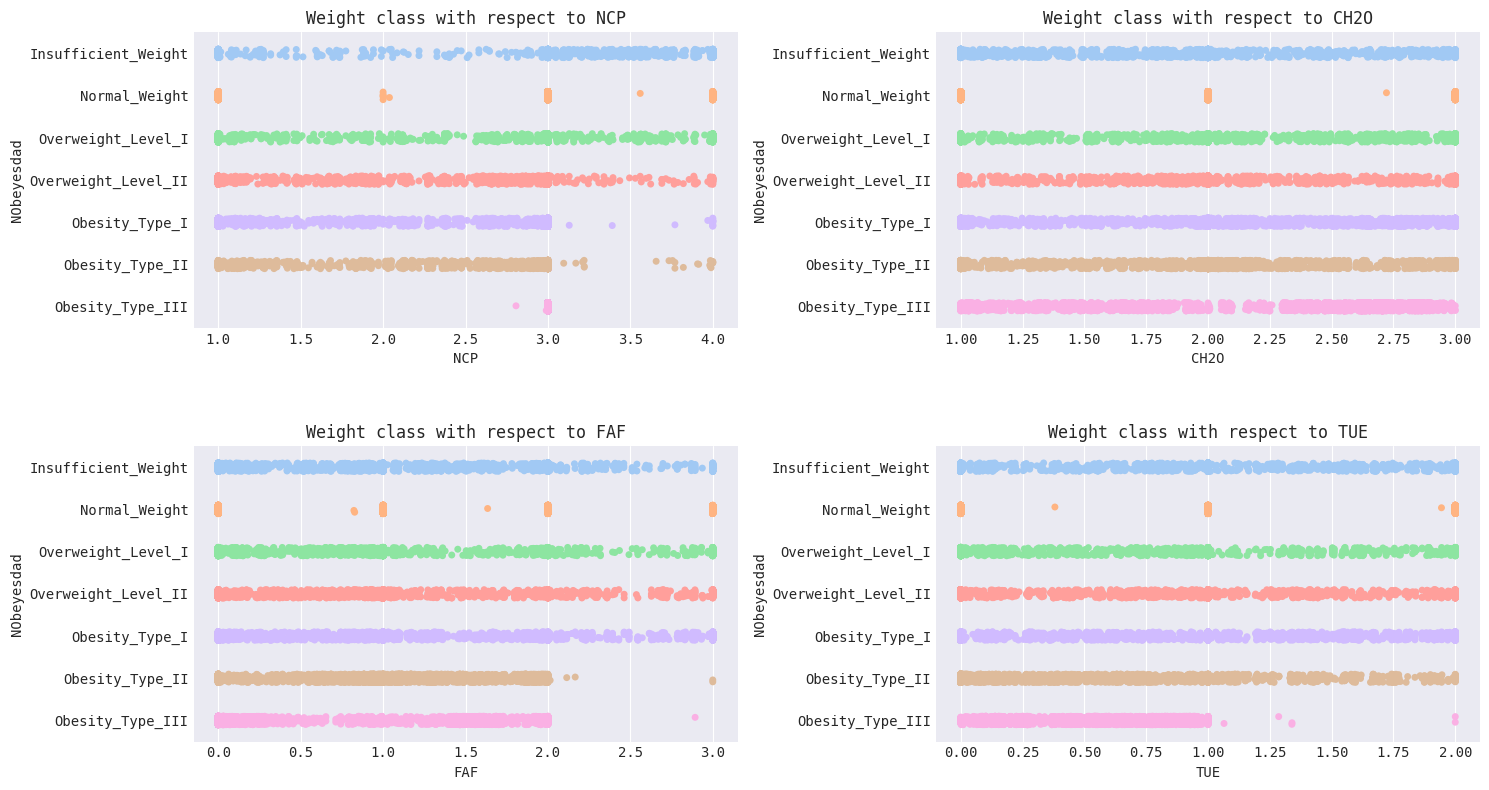

In [129]:
fig, axes = plt.subplots(2, 2, figsize=(15, 4*2))
axes = axes.flatten()
sns.stripplot(data=df, ax=axes[0], x='NCP', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[1], x='CH2O', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[2], x='FAF', y='NObeyesdad', palette='pastel', order=category_order)
sns.stripplot(data=df, ax=axes[3], x='TUE', y='NObeyesdad', palette='pastel', order=category_order)

# Title for each subplots
axes[0].set_title('Weight class with respect to NCP')
axes[1].set_title('Weight class with respect to CH2O')
axes[2].set_title('Weight class with respect to FAF')
axes[3].set_title('Weight class with respect to TUE')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 

# Show the plot
plt.show()

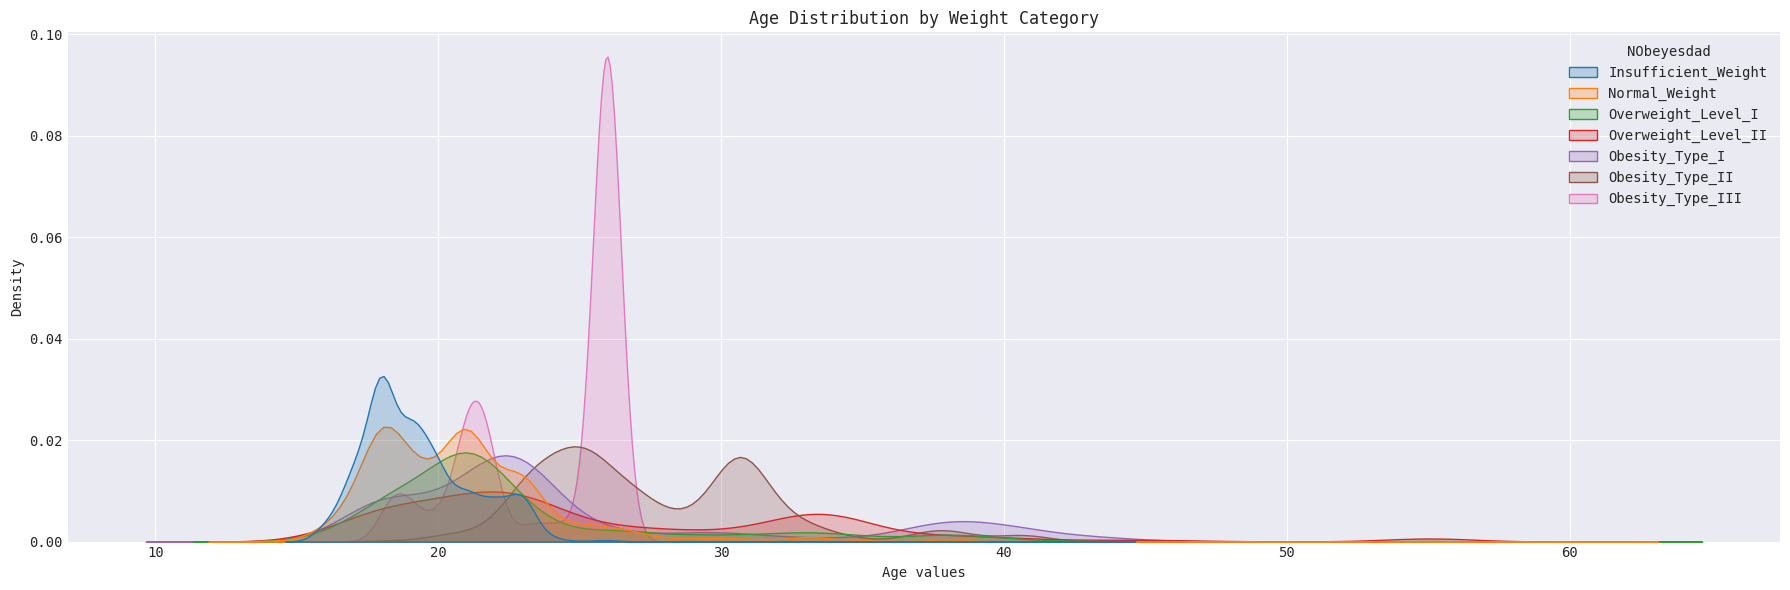

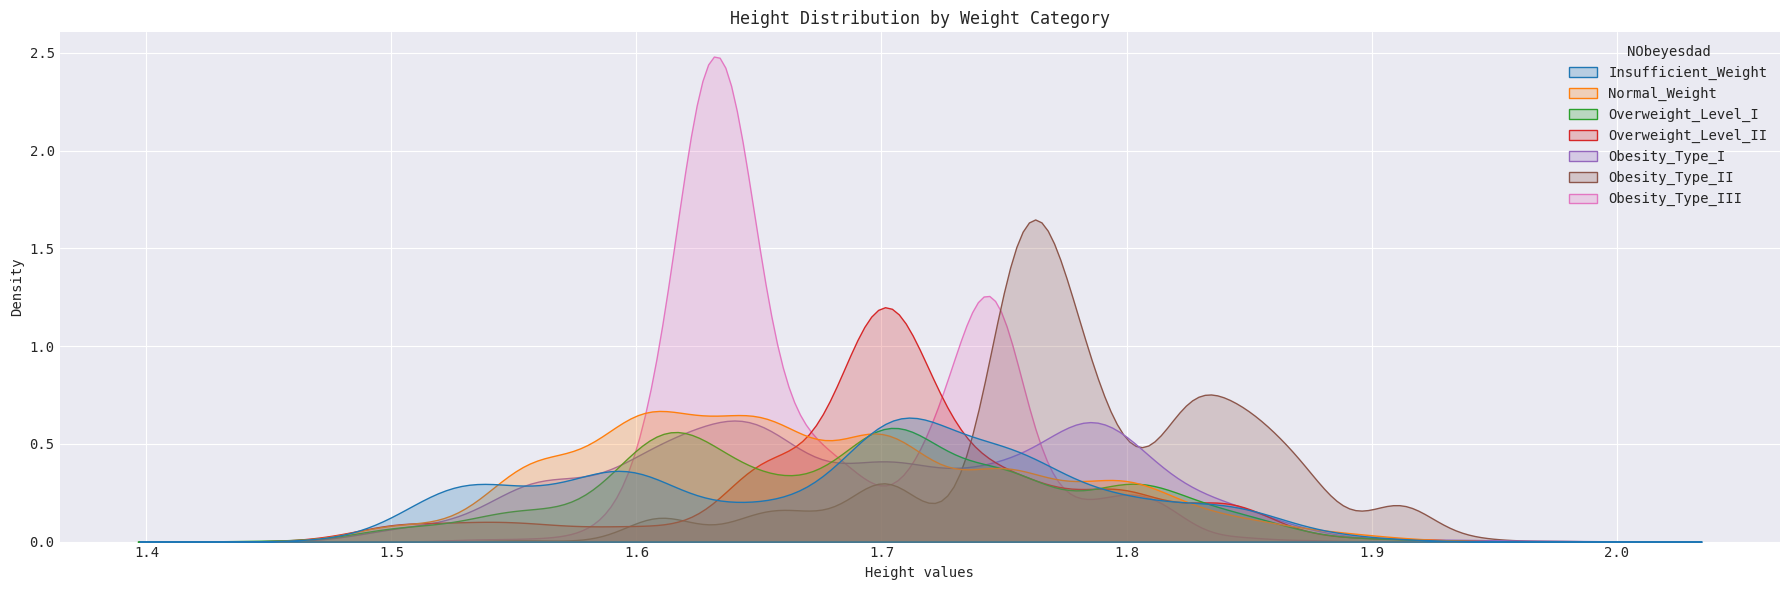

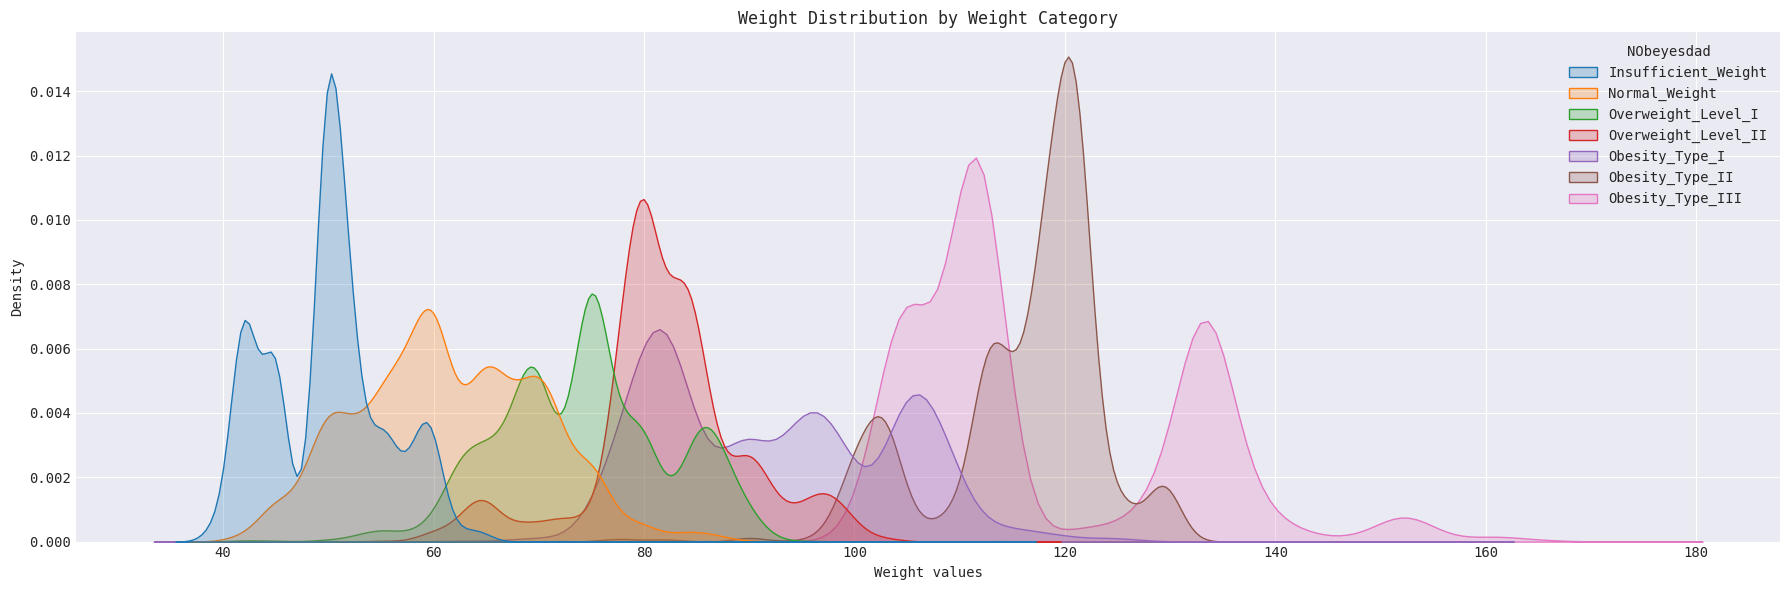

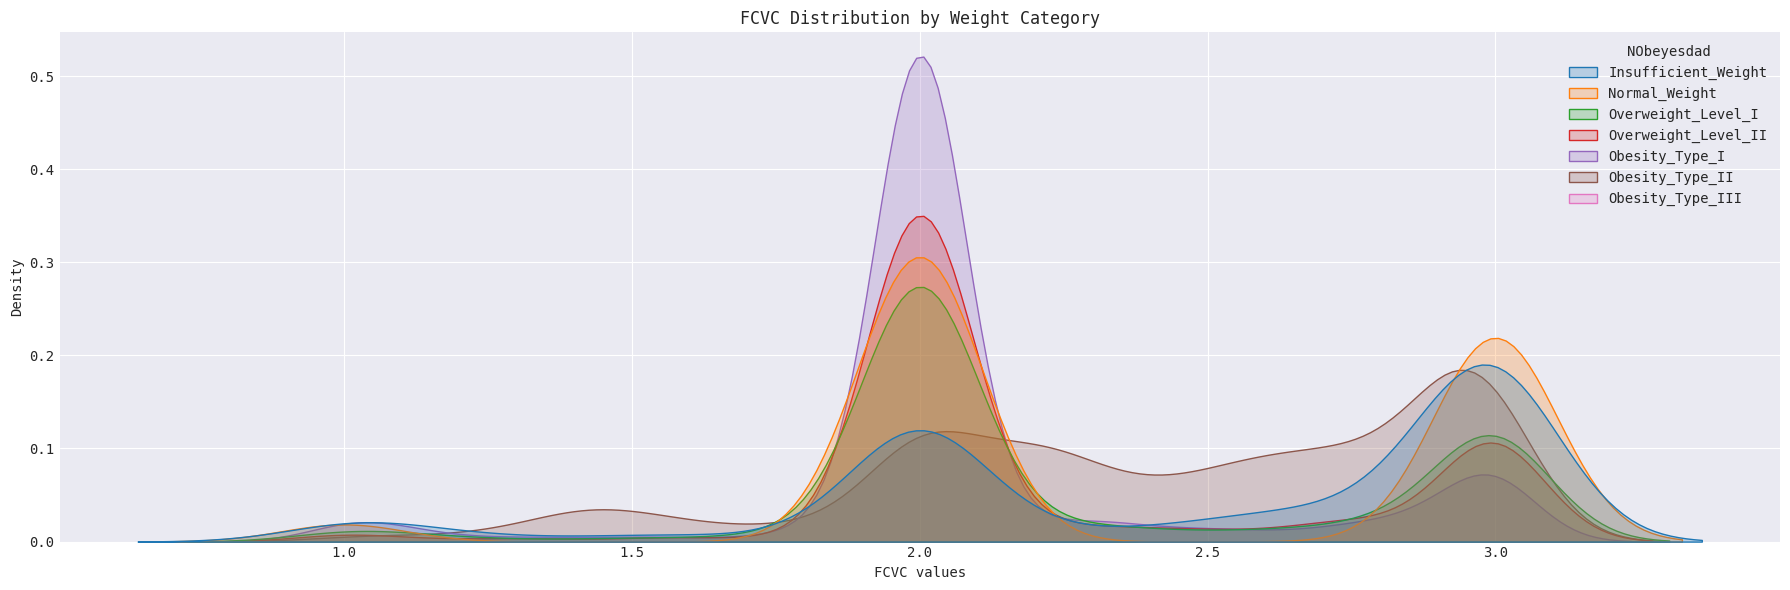

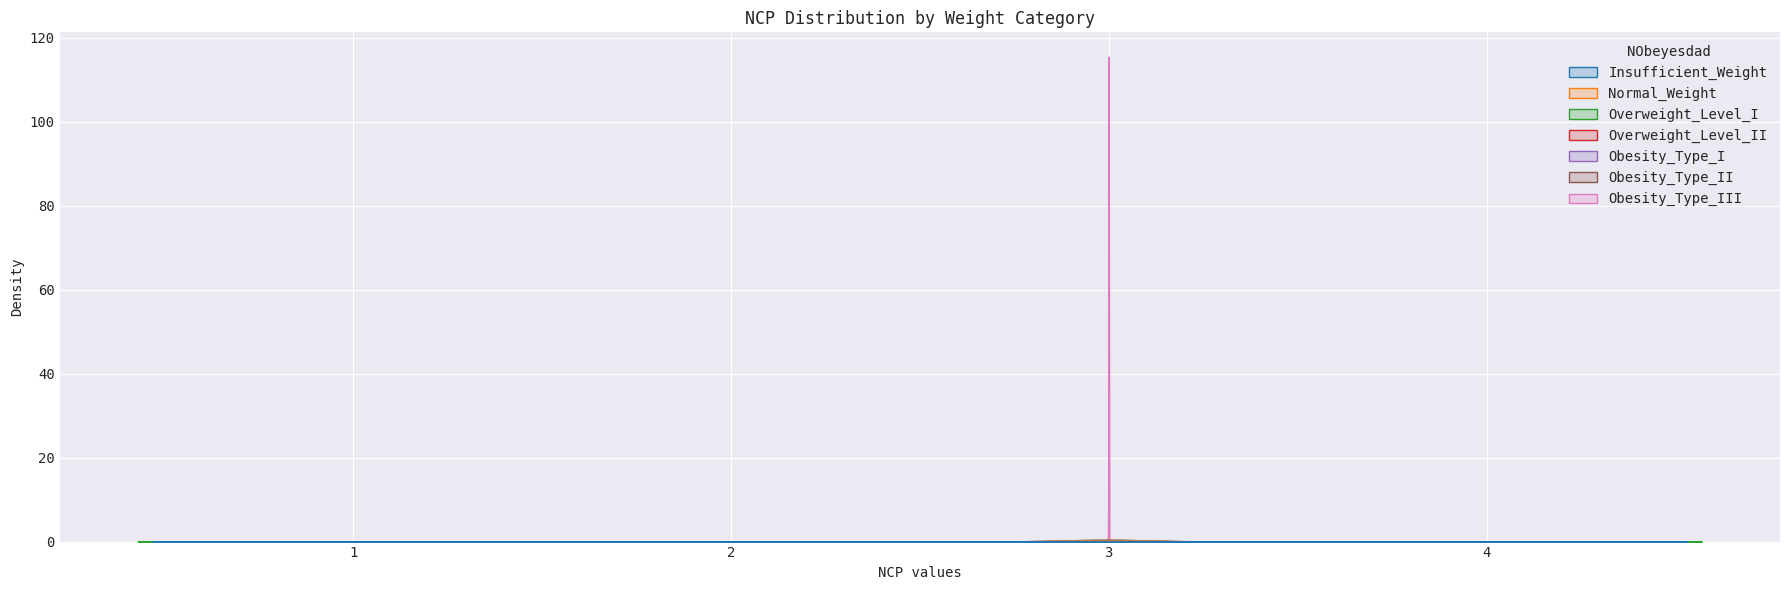

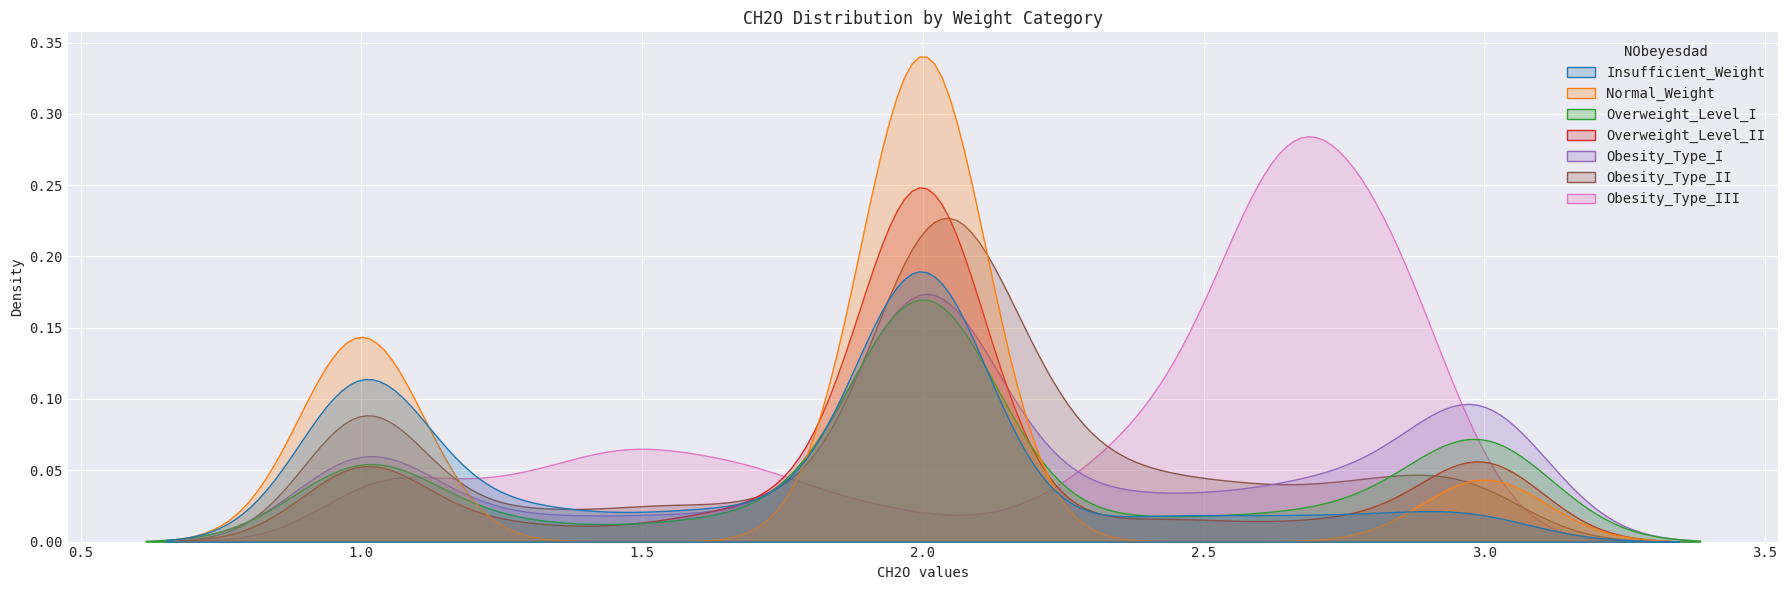

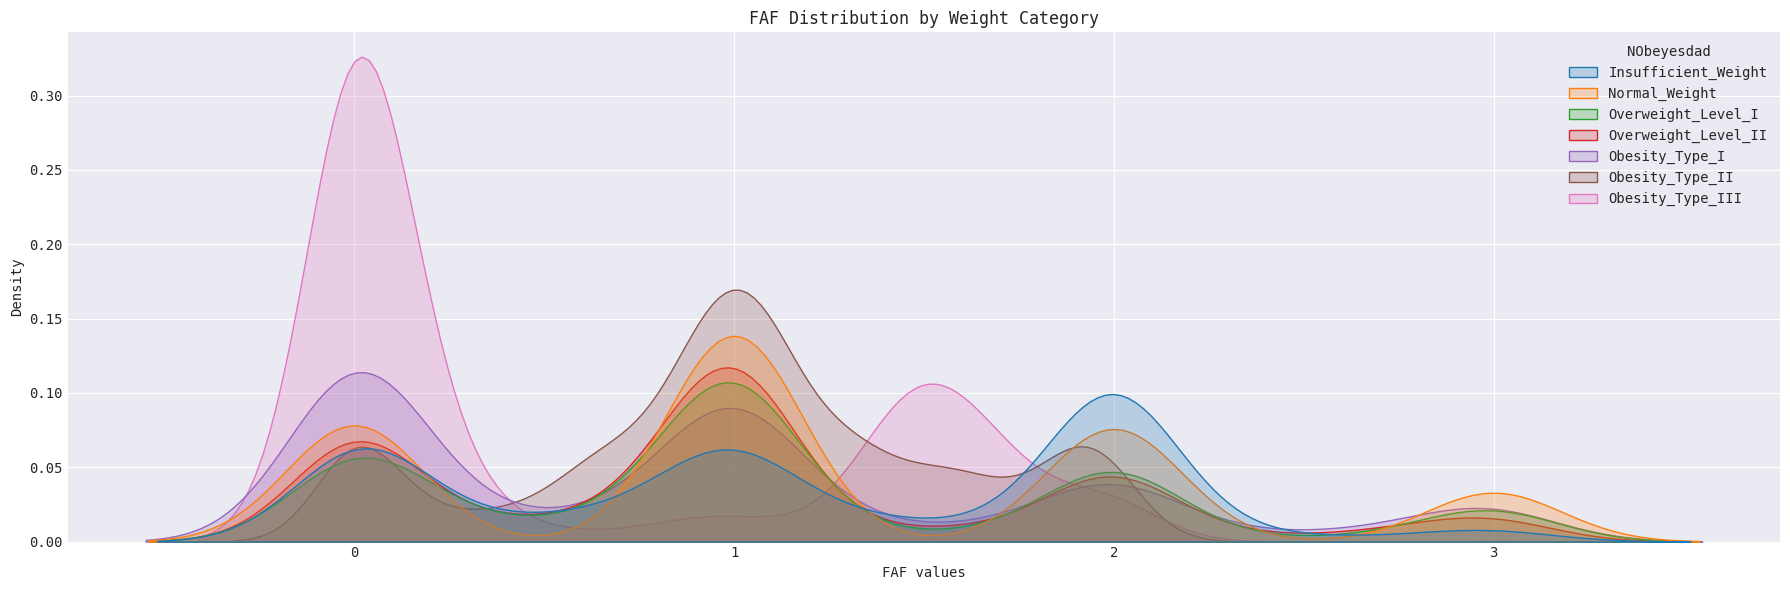

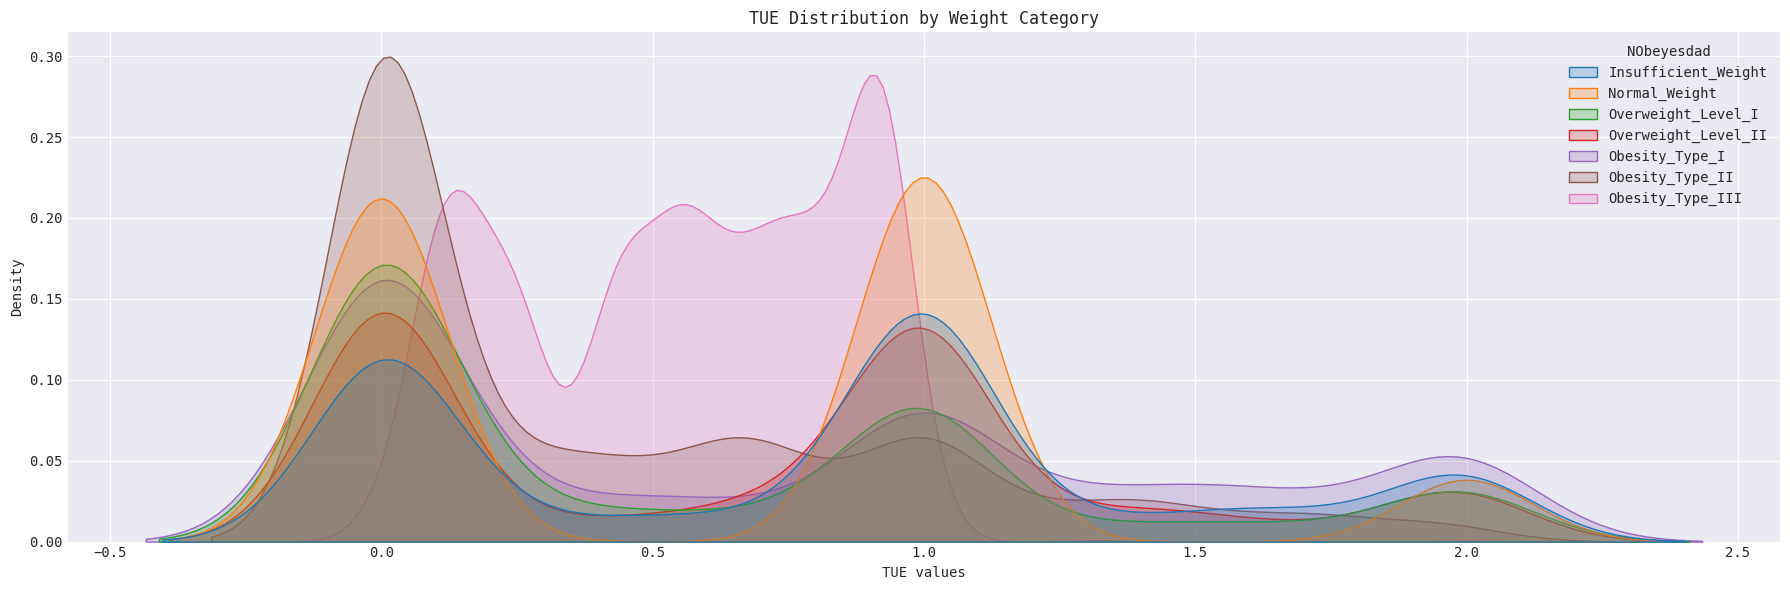

In [130]:
# Convert the 'NObeyesdad' column to categorical with the specified order
df['NObeyesdad'] = pd.Categorical(df['NObeyesdad'], categories=category_order, ordered=True)

# Map the categorical codes to integers
df['NObeyesdad_code'] = df['NObeyesdad'].cat.codes

# Sort the DataFrame based on 'NObeyesdad_code' (optional, for display purposes)
df_sorted = df.sort_values('NObeyesdad_code')
for col in numerical_cols:
    plt.figure(figsize=(18,6))
    # KDE plot for distribution
    sns.kdeplot(data=df_sorted, x=col, hue='NObeyesdad', palette=sns.color_palette("tab10"), 
                fill=True)
    plt.xlabel(f'{col} values')
    plt.title(f'{col} Distribution by Weight Category')
    
    plt.tight_layout()
    plt.show()

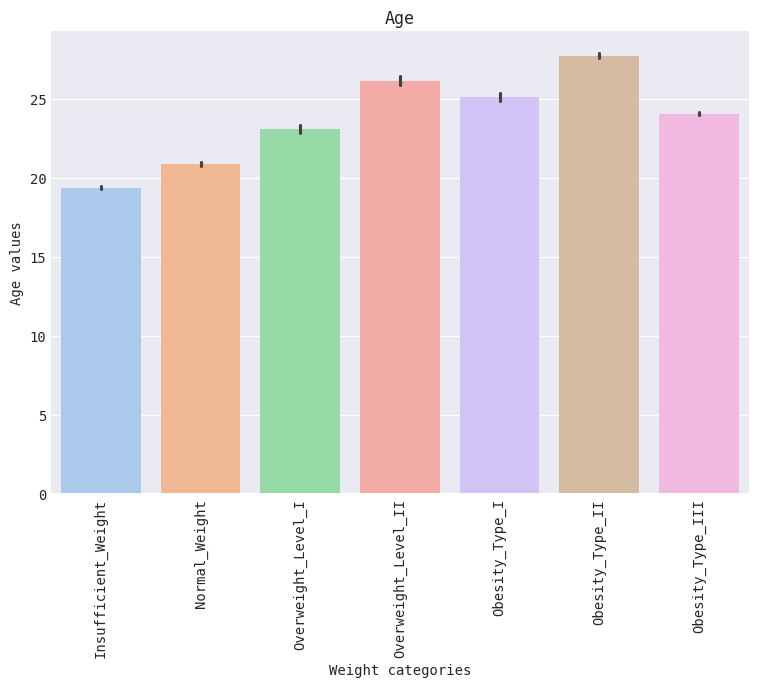

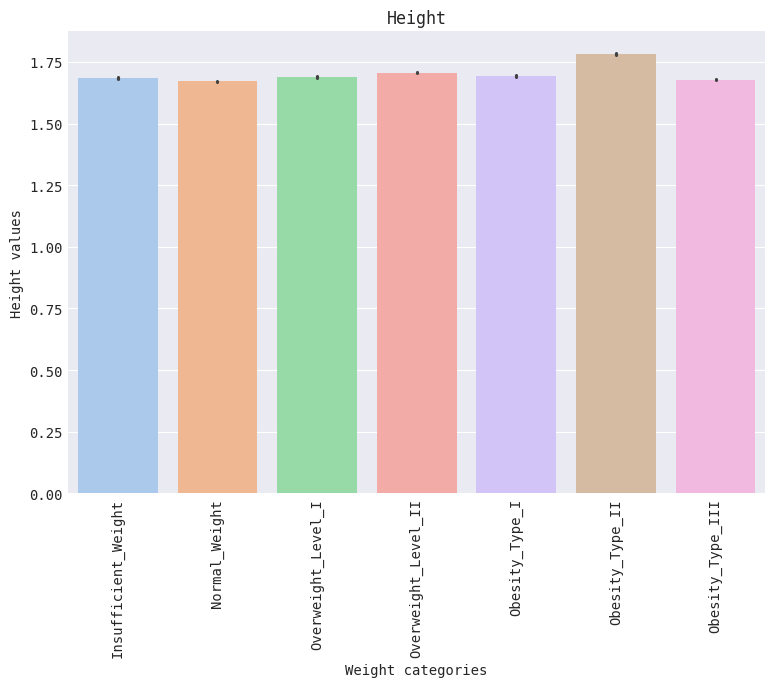

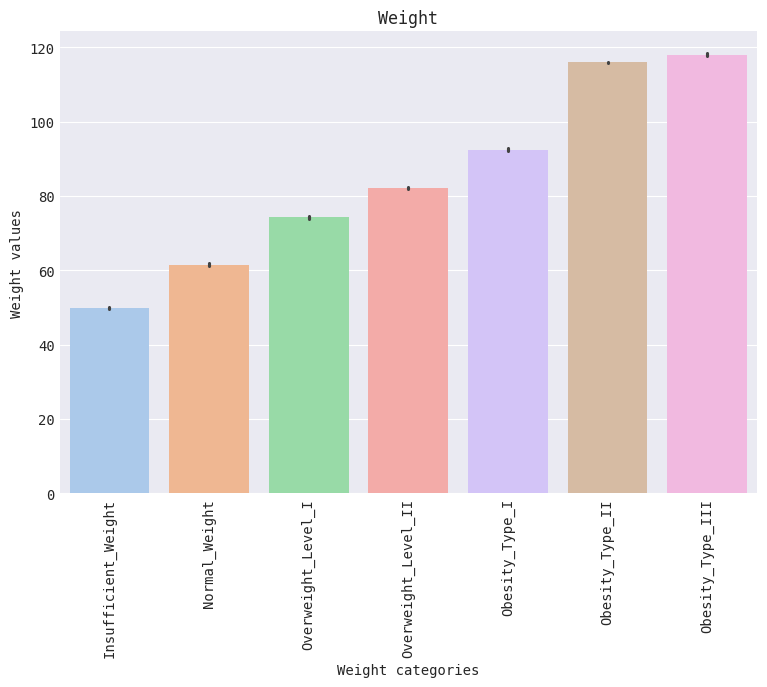

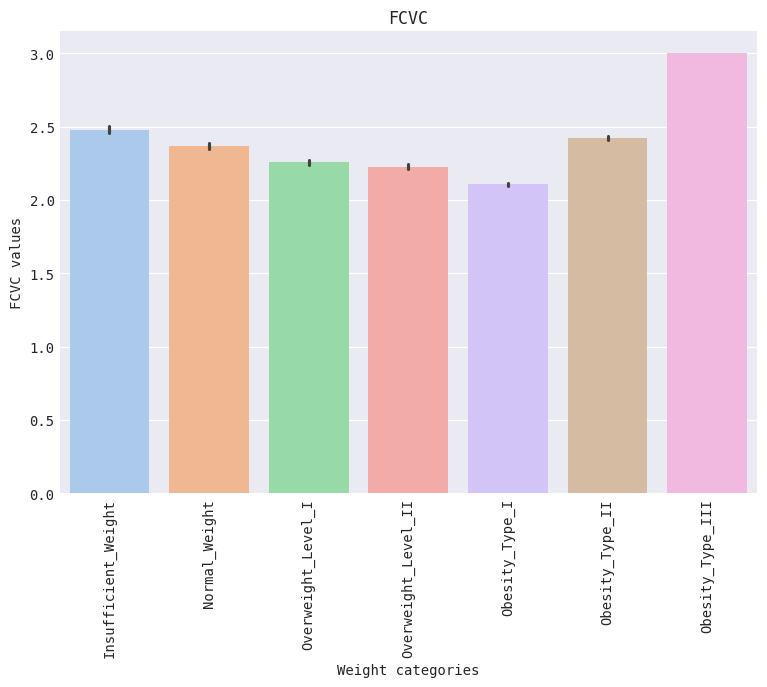

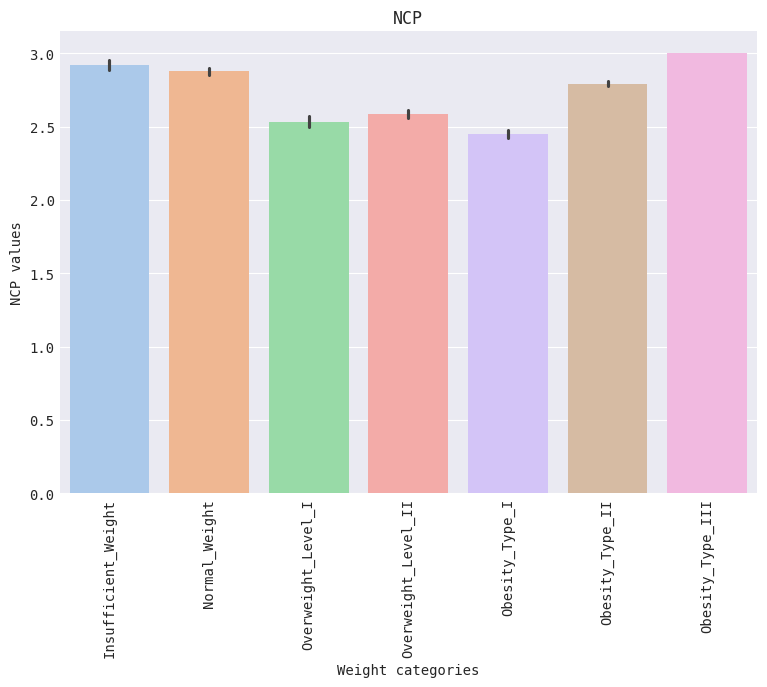

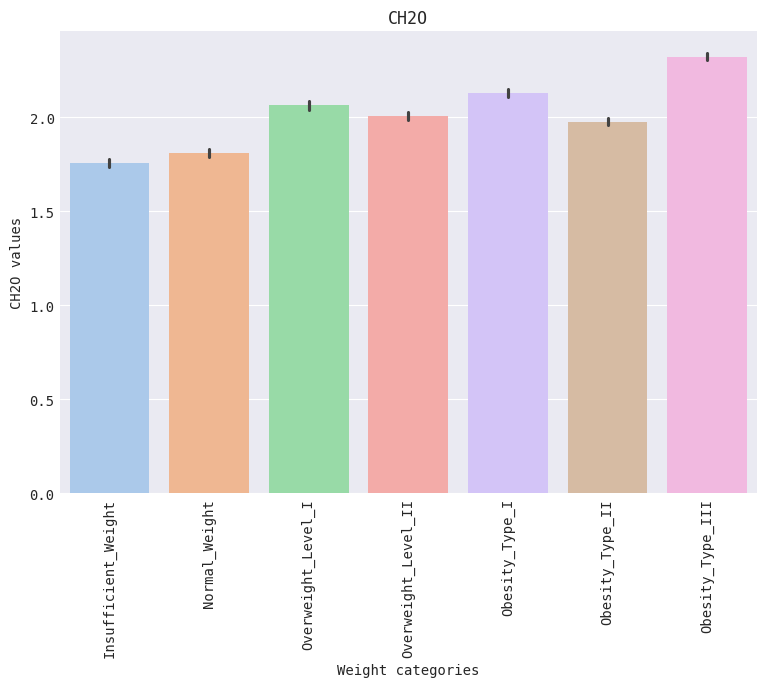

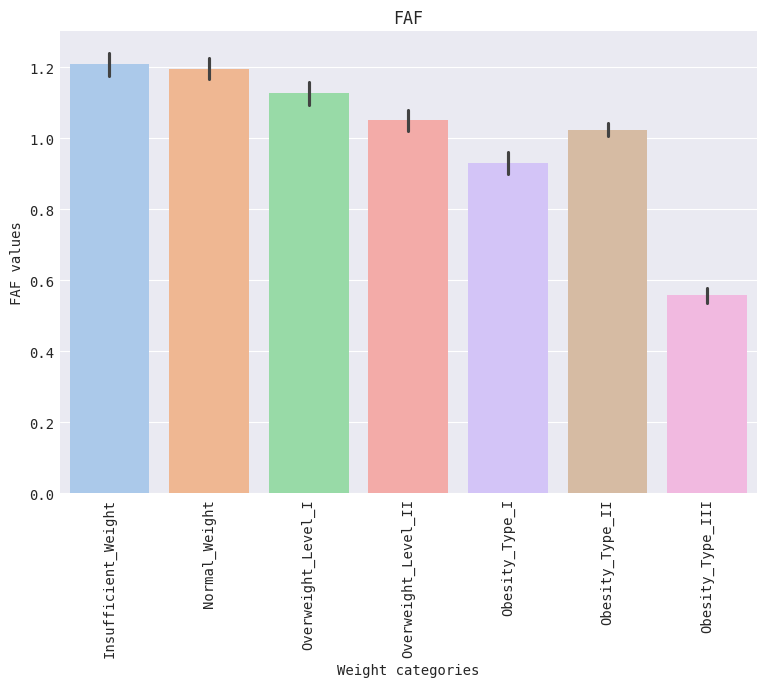

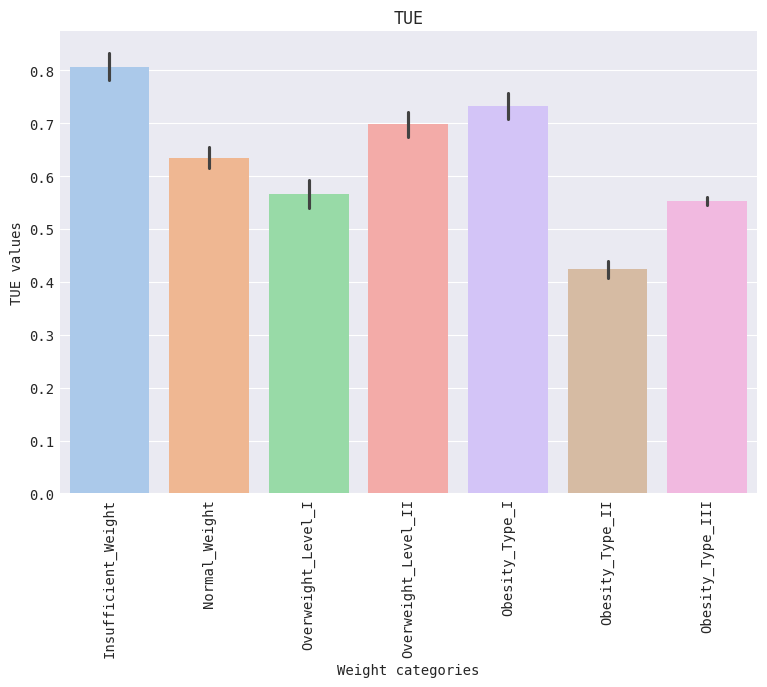

In [131]:
for col in numerical_cols:
    plt.figure(figsize=(9,6))
    sns.barplot(x='NObeyesdad', y=col, data=df, palette='pastel', order = category_order)
    plt.xticks(rotation=90)
    plt.xlabel('Weight categories')
    plt.ylabel(f'{col} values')
    plt.title(f'{col}')
    
plt.show()


#### Relationship between categorical features and target classes

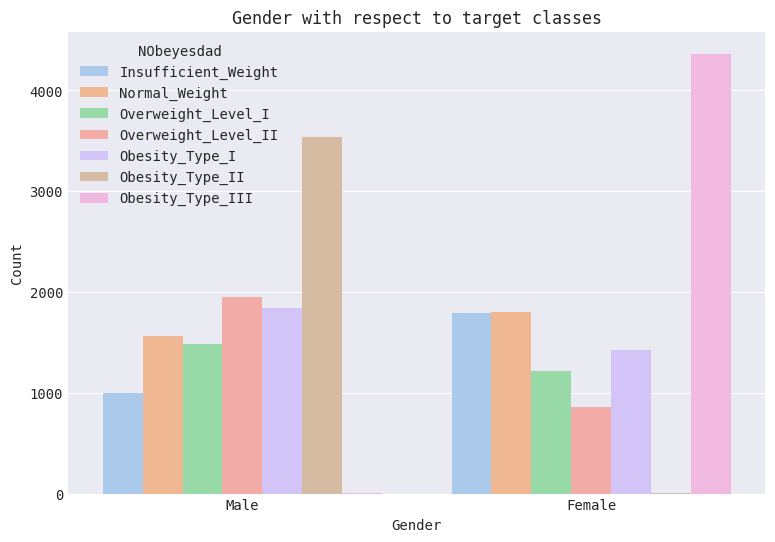

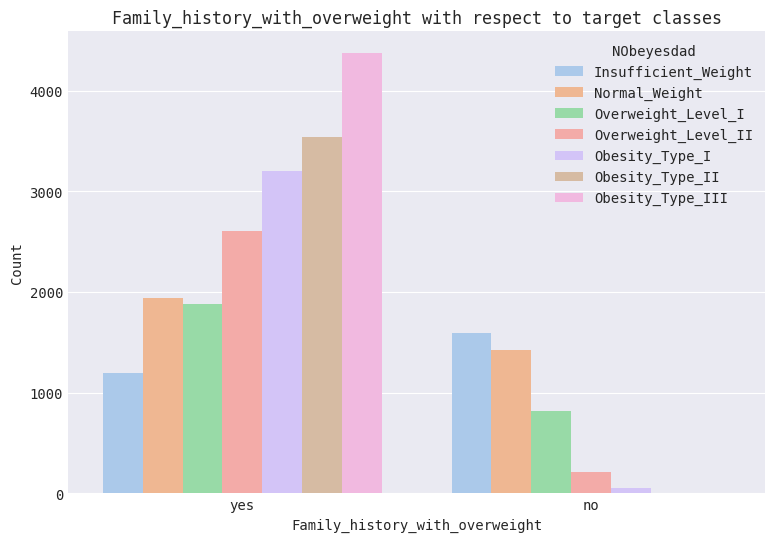

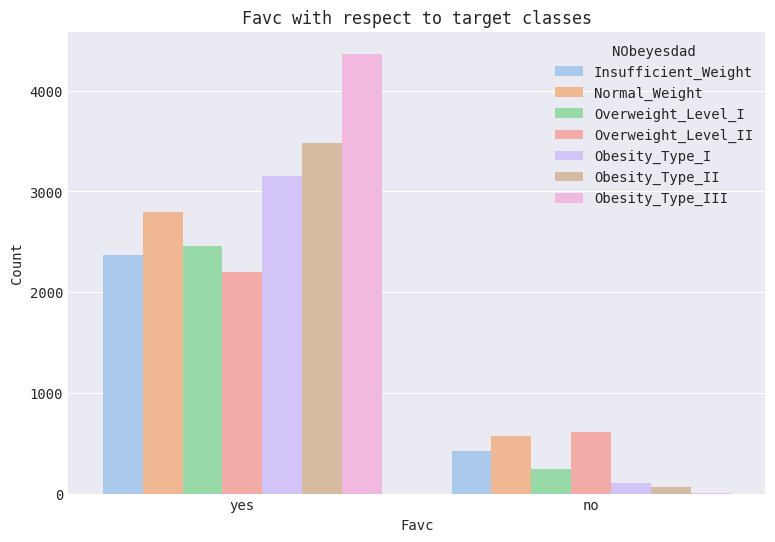

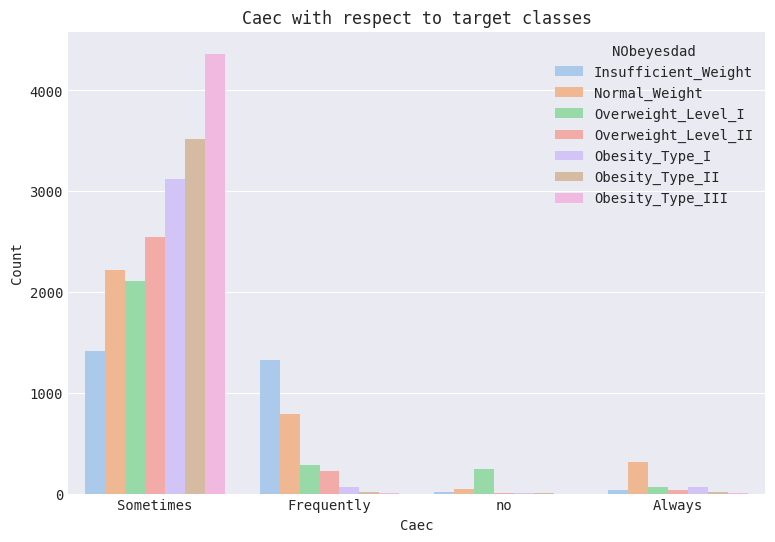

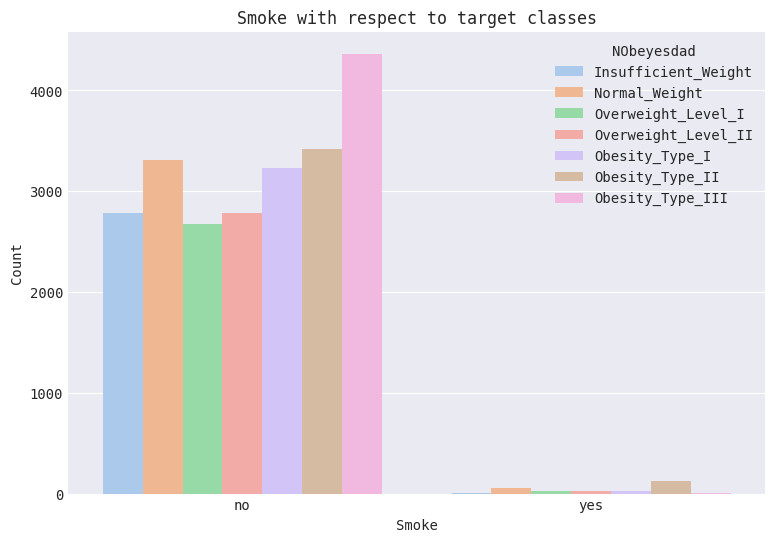

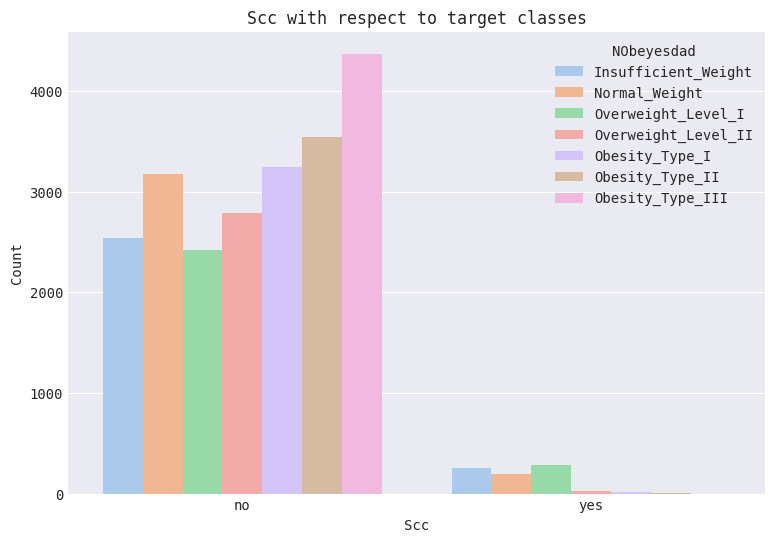

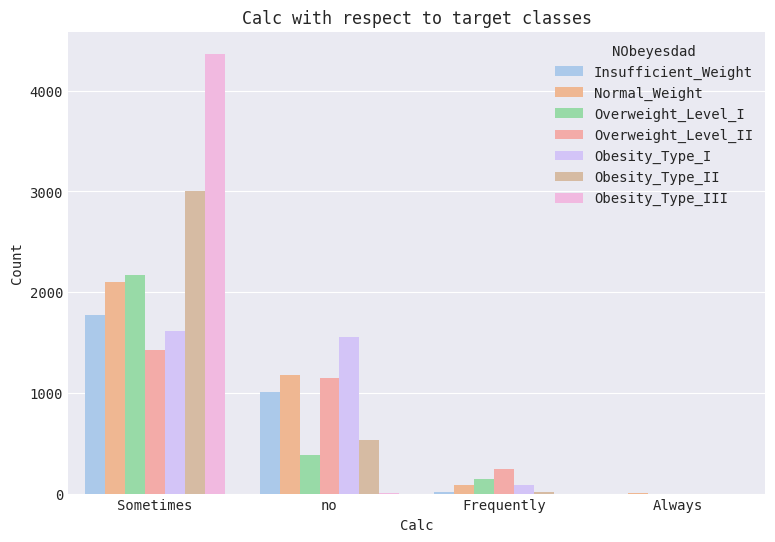

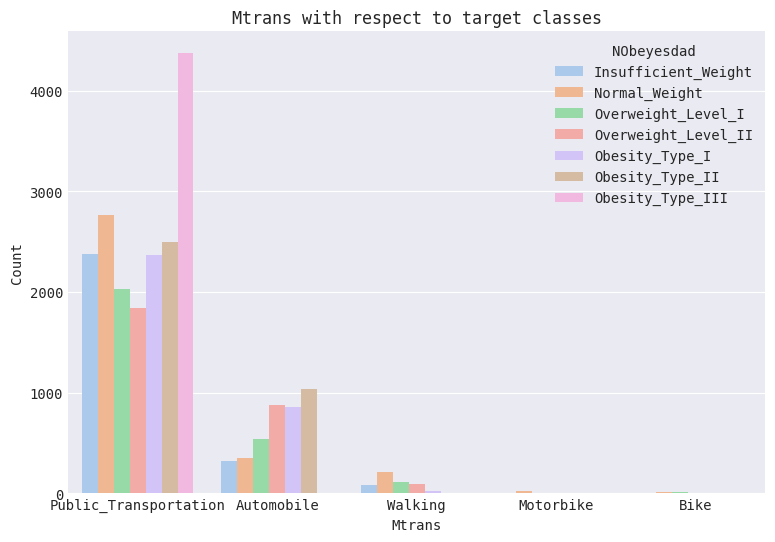

In [132]:
for col in categorical_cols:
    plt.figure(figsize=(9, 6))
    sns.countplot(data=df, x=col, hue='NObeyesdad', palette='pastel', hue_order=category_order)
    plt.title(f"{col.capitalize()} with respect to target classes")
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.legend(title='NObeyesdad')
    plt.show()

#### Relationship between features

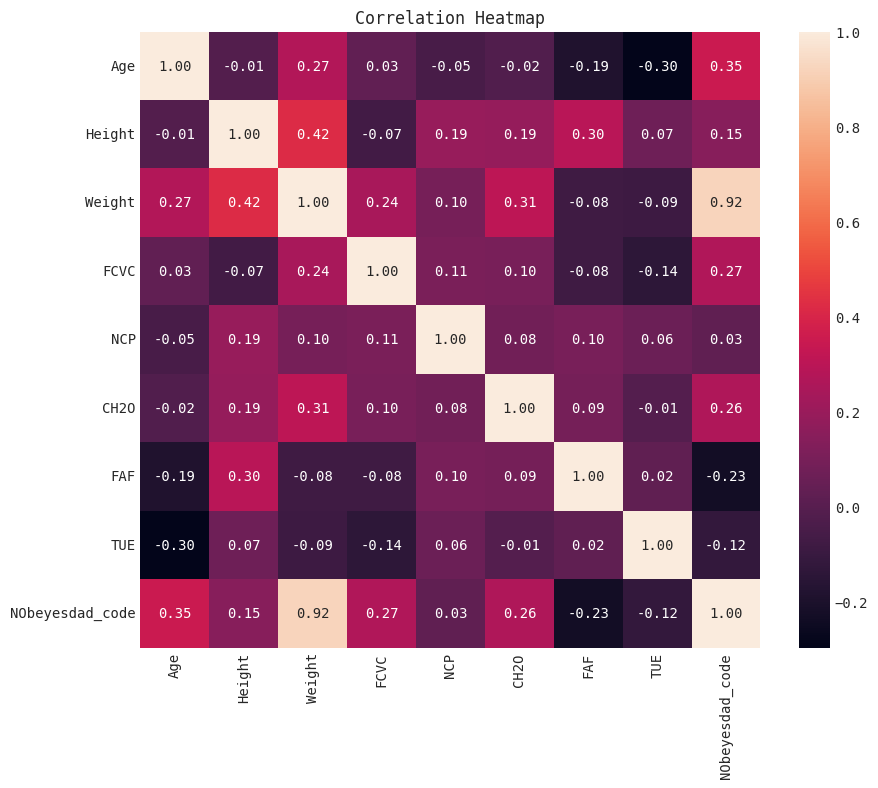

In [133]:
corr = df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

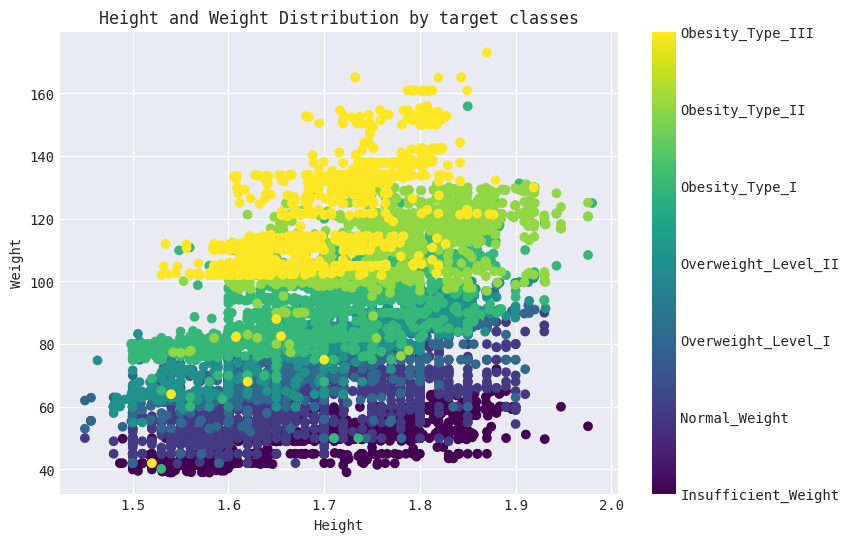

In [134]:
# Create the scatter plot
plt.figure(figsize=(9, 6))
scatter = plt.scatter(df_sorted['Height'], df_sorted['Weight'], c=df_sorted['NObeyesdad_code'], cmap='viridis')

# Set labels and title
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height and Weight Distribution by target classes')

# Customize the colorbar to match the category order
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(category_order)))
cbar.set_ticklabels(category_order)

# Display the plot
plt.show()

# 4. Data Preprocessing

In [135]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

# Encode target classes 
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}
y = y.map(mapping)
print(y)

0        3
1        1
2        0
3        6
4        3
        ..
22840    6
22841    6
22842    6
22843    6
22844    6
Name: NObeyesdad, Length: 22845, dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]


In [136]:
#Transform the distribution of Age into normal distribution
df['Age'], _  = boxcox(df['Age'])

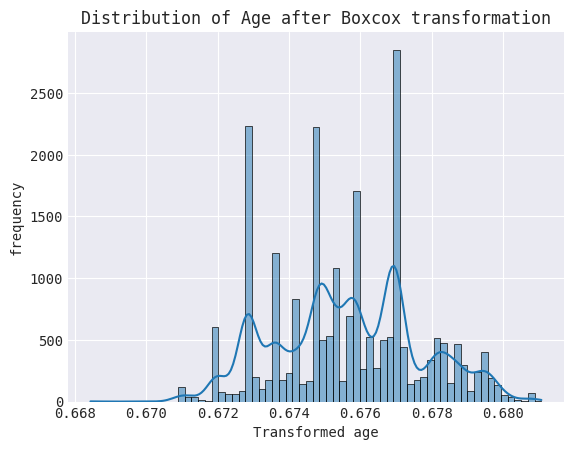

In [137]:
sns.histplot(data=df, x='Age', palette='pastel', kde=True)
plt.title('Distribution of Age after Boxcox transformation')
plt.xlabel('Transformed age')
plt.ylabel('frequency')
plt.show()

In [138]:
#Transform FCVC, NCP, CH2O, FAF, TUE into discrete values
df['FCVC'] = pd.cut(df['FCVC'],
                                bins=[0.5,1.5,2.5,3.5],
                                labels=[1,2,3]).astype('float64')
df['NCP'] = pd.cut(df['NCP'],
                                bins=[0.5,1.5,2.5,3.5,4.5],
                                labels=[1,2,3,4]).astype('float64')
df['CH2O'] = pd.cut(df['CH2O'],
                                bins=[0.5,1.5,2.5,3.5],
                                labels=[1,2,3]).astype('float64')
df['FAF'] = pd.cut(df['FAF'],
                                bins=[-0.5,0.5,1.5,2.5,3.5],
                                labels=[0,1,2,3]).astype('float64')
df['TUE'] = pd.cut(df['TUE'],
                                bins=[-0.5,0.5,1.5,2.5],
                                labels=[0,1,2]).astype('float64')

In [139]:
#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=RANDOM_STATE)

In [140]:
print(X_train.shape)
print(X_test.shape)

(18276, 17)
(4569, 17)


In [141]:
#Check the distribution of target classes in train and test set
print(y_train.value_counts() / y_train.shape[0])
print(y_test.value_counts() / y_test.shape[0])
X_train 

NObeyesdad
6    0.191289
5    0.155176
1    0.147242
4    0.142756
3    0.123112
0    0.122127
2    0.118297
Name: count, dtype: float64
NObeyesdad
6    0.191289
5    0.155176
1    0.147297
4    0.142701
3    0.123003
0    0.122127
2    0.118407
Name: count, dtype: float64


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad_code
21828,Female,25.293202,1.503379,64.342459,yes,no,2.000000,1.000000,Sometimes,no,1.639807,no,0.072117,0.000000,no,Public_Transportation,3
6944,Male,29.000000,1.770000,105.000000,yes,yes,2.000000,3.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Automobile,4
217,Male,23.586058,1.824414,106.421042,yes,yes,2.000000,3.000000,Sometimes,no,2.640483,no,0.285889,1.000000,Sometimes,Automobile,4
15891,Female,20.000000,1.600000,72.000000,no,yes,3.000000,3.000000,Sometimes,no,3.000000,no,2.000000,0.000000,no,Public_Transportation,3
3341,Male,20.000000,1.710000,68.000000,yes,no,3.000000,3.000000,Sometimes,no,3.000000,no,2.000000,0.000000,no,Walking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10761,Male,34.044229,1.691303,84.753830,yes,yes,2.000000,1.867836,Sometimes,no,2.288604,no,1.747347,0.000000,no,Automobile,3
20568,Male,18.000000,1.770000,50.000000,no,yes,3.000000,3.000000,Sometimes,no,1.000000,no,1.000000,1.000000,Sometimes,Public_Transportation,0
725,Female,26.000000,1.622703,105.580491,yes,yes,3.000000,3.000000,Sometimes,no,2.351207,no,0.000000,0.481031,Sometimes,Public_Transportation,6
17727,Male,25.816445,1.855779,117.398976,yes,yes,2.630137,3.000000,Sometimes,no,2.386904,no,1.285898,0.290898,Sometimes,Public_Transportation,5


In [142]:
# data preprocessing, why not drop 1 col in 1-hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always']] * 2)
scaler = StandardScaler()
col_trans = make_column_transformer(
    (ohe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    (oe, ['CAEC', 'CALC']),
    (scaler, ['Age', 'Height', 'Weight']),
    remainder='passthrough',
    n_jobs=-1
)
col_trans.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always']]),
                                 ['CAEC', 'CALC']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight'])])

In [143]:
X_train.drop(columns=['NObeyesdad_code'], inplace=True)
X_test.drop(columns=['NObeyesdad_code'], inplace=True)
# Preprocess train and test sets
X_train_processed = col_trans.fit_transform(X_train)
X_test_processed = col_trans.transform(X_test)

# Save the ColumnTransformer to a file
filename = os.path.join('checkpoint/', 'preprocessing.joblib')
joblib.dump(col_trans,filename)

['checkpoint/preprocessing.joblib']

In [144]:
X_train_processed

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,ordinalencoder__CAEC,ordinalencoder__CALC,standardscaler__Age,standardscaler__Height,standardscaler__Weight,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
21828,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.250197,-2.238554,-0.888368,2.000000,1.000000,1.639807,0.072117,0.000000
6944,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.899666,0.796385,0.653650,2.000000,3.000000,3.000000,1.000000,0.000000
217,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.048913,1.415778,0.707546,2.000000,3.000000,2.640483,0.285889,1.000000
15891,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.677227,-1.138720,-0.597941,3.000000,3.000000,3.000000,2.000000,0.000000
3341,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.677227,0.113407,-0.749649,3.000000,3.000000,3.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10761,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.783468,-0.099421,-0.114227,2.000000,1.867836,2.288604,1.747347,0.000000
20568,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.027648,0.796385,-1.432335,3.000000,3.000000,1.000000,1.000000,1.000000
725,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.374035,-0.880292,0.675666,3.000000,3.000000,2.351207,0.000000,0.481031
17727,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.341874,1.772805,1.123905,2.630137,3.000000,2.386904,1.285898,0.290898


In [145]:
X_test_processed

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,ordinalencoder__CAEC,ordinalencoder__CALC,standardscaler__Age,standardscaler__Height,standardscaler__Weight,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
12643,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.677227,-0.000423,-0.749649,2.000000,1.000000,2.000000,0.000000,1.000000
15927,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,-0.502017,-0.000423,-0.806539,2.000000,3.000000,2.000000,3.000000,0.000000
8493,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.647153,0.831843,1.245346,2.913452,3.000000,2.795752,0.882709,0.646760
14486,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.027648,0.593836,-0.294525,2.000000,1.000000,1.081719,1.000000,0.062167
17400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.151596,-0.341912,-1.053065,3.000000,3.000000,2.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.374035,-0.822069,0.916510,3.000000,3.000000,2.682804,0.000000,0.151710
4143,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.162792,0.757080,0.605996,2.908757,2.806341,1.732072,0.822186,0.000000
17670,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.460051,1.121710,-0.196561,2.661556,3.000000,2.191401,0.979306,1.915818
16262,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.374035,-0.752985,0.914516,3.000000,3.000000,2.621976,0.000000,0.153462


# 5.EXPERIMENT

In [146]:
df_results = pd.DataFrame()

In [147]:
#function to tune hyperparameters
def hyper_search(model, model_name, param_grid, X_train, y_train, cv=5, n_iter=20, scoring='accuracy', random_state=RANDOM_STATE):
    global df_results
    # Hyperparameter tuning
    rs = RandomizedSearchCV(model, param_grid, n_iter=n_iter, n_jobs=-1, cv=StratifiedKFold(n_splits=cv), scoring=scoring, return_train_score=True, random_state=random_state)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    
    #add the report about best hyperparameter of the model to dataframe
    result = pd.DataFrame(rs.cv_results_)
    result.sort_values('rank_test_score', inplace=True)
    result = result[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']]
    display(result)
    best_hyper = result.loc[result['params']==rs.best_params_]
    best_hyper['model_name'] = model_name
    df_results = pd.concat([df_results, best_hyper], ignore_index=True)
    
    #save the model
    filename = os.path.join('checkpoint/', f'{model_name}.joblib')
    joblib.dump(best_model,filename)
    
#     #save report results
#     df_results.to_csv('report_result.csv')
    
    return best_model

#### KNN

In [148]:
param_grid = [{
    'n_neighbors': [3, 5, 7, 9, 11,20],
    'p': [1, 2],
}]
knn = hyper_search(
    model=KNeighborsClassifier(),
    model_name='KNN',
    param_grid=param_grid,
    X_train=X_train_processed,
    y_train=y_train,
    cv=5,
    n_iter=20,
    scoring='accuracy',
    random_state=RANDOM_STATE
)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
6,"{'p': 1, 'n_neighbors': 9}",0.008529,1.632976,0.827479,0.864467
8,"{'p': 1, 'n_neighbors': 11}",0.008853,1.598863,0.827260,0.859803
10,"{'p': 1, 'n_neighbors': 20}",0.008246,1.640101,0.826330,0.847806
4,"{'p': 1, 'n_neighbors': 7}",0.007328,1.674716,0.823868,0.870034
2,"{'p': 1, 'n_neighbors': 5}",0.009442,1.704675,0.819326,0.877626
0,"{'p': 1, 'n_neighbors': 3}",0.010543,1.904573,0.804006,0.893481
7,"{'p': 2, 'n_neighbors': 9}",0.008203,0.552799,0.802145,0.841691
9,"{'p': 2, 'n_neighbors': 11}",0.007413,0.554889,0.802036,0.836972
5,"{'p': 2, 'n_neighbors': 7}",0.007287,0.558909,0.800668,0.850159
11,"{'p': 2, 'n_neighbors': 20}",0.006663,0.655464,0.797768,0.819900


#### Logistic Regression

In [149]:
param_grid = [{
        'C': [1e-1, 1, 10, 100, 1000],
        'penalty': ['l2']
    },
{
    'penalty': [None]
}]
logreg = hyper_search(LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic_regression', param_grid, X_train_processed, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
2,"{'penalty': 'l2', 'C': 10}",5.769829,0.007664,0.870924,0.872483
4,"{'penalty': 'l2', 'C': 1000}",3.702791,0.006323,0.870924,0.872825
5,{'penalty': None},2.612836,0.002707,0.870869,0.872907
3,"{'penalty': 'l2', 'C': 100}",4.318787,0.007410,0.870705,0.872825
1,"{'penalty': 'l2', 'C': 1}",4.238646,0.007163,0.865890,0.868475
0,"{'penalty': 'l2', 'C': 0.1}",2.998715,0.008301,0.835303,0.836917


#### Decision Tree

In [150]:
param_grid = [{
        'max_depth': [5, 10, 15, 20],
        'min_samples_leaf': [5, 10, 20, 30, 50],
        'criterion': ['gini', 'entropy']
    }]
decision_tree = hyper_search(DecisionTreeClassifier(random_state=RANDOM_STATE), 'decision_tree', param_grid, X_train_processed, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
7,"{'min_samples_leaf': 20, 'max_depth': 10, 'cri...",0.134986,0.003911,0.885040,0.898213
6,"{'min_samples_leaf': 20, 'max_depth': 20, 'cri...",0.149121,0.004316,0.884055,0.898884
3,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.150825,0.004495,0.883344,0.908281
10,"{'min_samples_leaf': 5, 'max_depth': 10, 'crit...",0.148856,0.004311,0.882140,0.915778
5,"{'min_samples_leaf': 20, 'max_depth': 15, 'cri...",0.129837,0.004109,0.881593,0.896668
16,"{'min_samples_leaf': 20, 'max_depth': 20, 'cri...",0.150626,0.004568,0.881593,0.896668
19,"{'min_samples_leaf': 30, 'max_depth': 15, 'cri...",0.172496,0.005170,0.881265,0.891921
9,"{'min_samples_leaf': 10, 'max_depth': 10, 'cri...",0.117833,0.006245,0.880718,0.905395
1,"{'min_samples_leaf': 10, 'max_depth': 20, 'cri...",0.129004,0.005225,0.880006,0.911127
12,"{'min_samples_leaf': 30, 'max_depth': 15, 'cri...",0.118320,0.004315,0.879951,0.890047


#### Random Forest

In [151]:
param_grid = [{
        'n_estimators': [100, 300, 500, 1000, 2000],
        'max_depth': [10, 20, 30],
        'min_samples_leaf': [10, 20, 30],
        'criterion': ['gini', 'entropy']
    }]
random_forest = hyper_search(RandomForestClassifier(random_state=RANDOM_STATE), 'random_forest', param_grid, X_train_processed, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
19,"{'n_estimators': 500, 'min_samples_leaf': 10, ...",14.471641,0.286352,0.897078,0.922672
16,"{'n_estimators': 1000, 'min_samples_leaf': 10,...",22.948649,0.580936,0.895218,0.922521
18,"{'n_estimators': 2000, 'min_samples_leaf': 10,...",44.669059,0.750578,0.892099,0.914410
15,"{'n_estimators': 2000, 'min_samples_leaf': 10,...",39.644549,1.018049,0.891059,0.911756
10,"{'n_estimators': 300, 'min_samples_leaf': 20, ...",8.900112,0.172426,0.888761,0.906503
1,"{'n_estimators': 500, 'min_samples_leaf': 20, ...",9.617118,0.260187,0.888378,0.906147
6,"{'n_estimators': 2000, 'min_samples_leaf': 20,...",41.678920,1.292206,0.888159,0.906571
4,"{'n_estimators': 100, 'min_samples_leaf': 10, ...",1.985322,0.052154,0.886846,0.909088
7,"{'n_estimators': 100, 'min_samples_leaf': 20, ...",2.448388,0.052579,0.886354,0.904465
11,"{'n_estimators': 100, 'min_samples_leaf': 20, ...",2.440425,0.056212,0.885369,0.904082


#### XGBoost

In [152]:
param_grid = [{
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 15, 20]
    }]
xg_boost = hyper_search(XGBClassifier(random_state=RANDOM_STATE), 'xg_boost', param_grid, X_train_processed, y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
10,"{'n_estimators': 300, 'max_depth': 20}",13.158921,0.555838,0.905012,1.000000
9,"{'n_estimators': 200, 'max_depth': 20}",9.717337,0.786773,0.904793,1.000000
5,"{'n_estimators': 200, 'max_depth': 15}",8.729899,0.441136,0.904574,1.000000
8,"{'n_estimators': 100, 'max_depth': 20}",6.158169,0.305177,0.904410,1.000000
0,"{'n_estimators': 100, 'max_depth': 10}",11.655412,0.273467,0.904301,0.999877
6,"{'n_estimators': 300, 'max_depth': 15}",11.572187,0.617612,0.904246,1.000000
11,"{'n_estimators': 500, 'max_depth': 20}",16.964780,0.570491,0.904246,1.000000
4,"{'n_estimators': 100, 'max_depth': 15}",5.983413,0.292256,0.904246,1.000000
7,"{'n_estimators': 500, 'max_depth': 15}",17.467122,0.861059,0.904082,1.000000
1,"{'n_estimators': 200, 'max_depth': 10}",15.395370,0.533709,0.903808,1.000000


In [153]:
print(df_results.loc[2, 'params'])


{'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'entropy'}


In [154]:
clf1 = XGBClassifier(random_state=RANDOM_STATE, max_depth=20, n_esimators = 300)
clf2 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators = 500, min_samples_leaf = 10, max_depth = 20, criterion = 'entropy')
clf3 = XGBClassifier(random_state=RANDOM_STATE, max_depth=20, n_esimators = 200)
votingClf = VotingClassifier(estimators=[
        ('xg1', clf1), ('rf2', clf2), ('xg2', clf3)], voting='soft')
votingClf_results = cross_validate(votingClf, X_train_processed, y_train, cv=5, n_jobs=-1, return_train_score=True)

In [155]:
votingClf_results = {
    'params': 'XGBClassifier, RandomForestClassifier',
    'mean_fit_time': np.mean(votingClf_results['fit_time']),
    'mean_score_time': np.mean(votingClf_results['score_time']),
    'mean_test_score': np.mean(votingClf_results['test_score']),
    'mean_train_score': np.mean(votingClf_results['train_score']),
    'model_name': 'voting_classifier'
}

df_results = pd.concat([df_results, pd.DataFrame([votingClf_results])], ignore_index=True)

In [156]:
votingClf.fit(X_train_processed, y_train)

VotingClassifier(estimators=[('xg1',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constra...
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_esimators=200, n_estimators=None,
                                            n_jobs=None, ...))],
                 voting='soft')

In [157]:
#save the model
filename = os.path.join('checkpoint/', 'votingClassifier.joblib')
joblib.dump(votingClf,filename)

['checkpoint/votingClassifier.joblib']

In [158]:
df_results

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_name
0,"{'p': 1, 'n_neighbors': 9}",0.008529,1.632976,0.827479,0.864467,KNN
1,"{'penalty': 'l2', 'C': 10}",5.769829,0.007664,0.870924,0.872483,logistic_regression
2,"{'min_samples_leaf': 20, 'max_depth': 10, 'cri...",0.134986,0.003911,0.885040,0.898213,decision_tree
3,"{'n_estimators': 500, 'min_samples_leaf': 10, ...",14.471641,0.286352,0.897078,0.922672,random_forest
4,"{'n_estimators': 300, 'max_depth': 20}",13.158921,0.555838,0.905012,1.000000,xg_boost
5,"XGBClassifier, RandomForestClassifier",18.570783,0.584493,0.905286,1.000000,voting_classifier


#### Feature Engineering

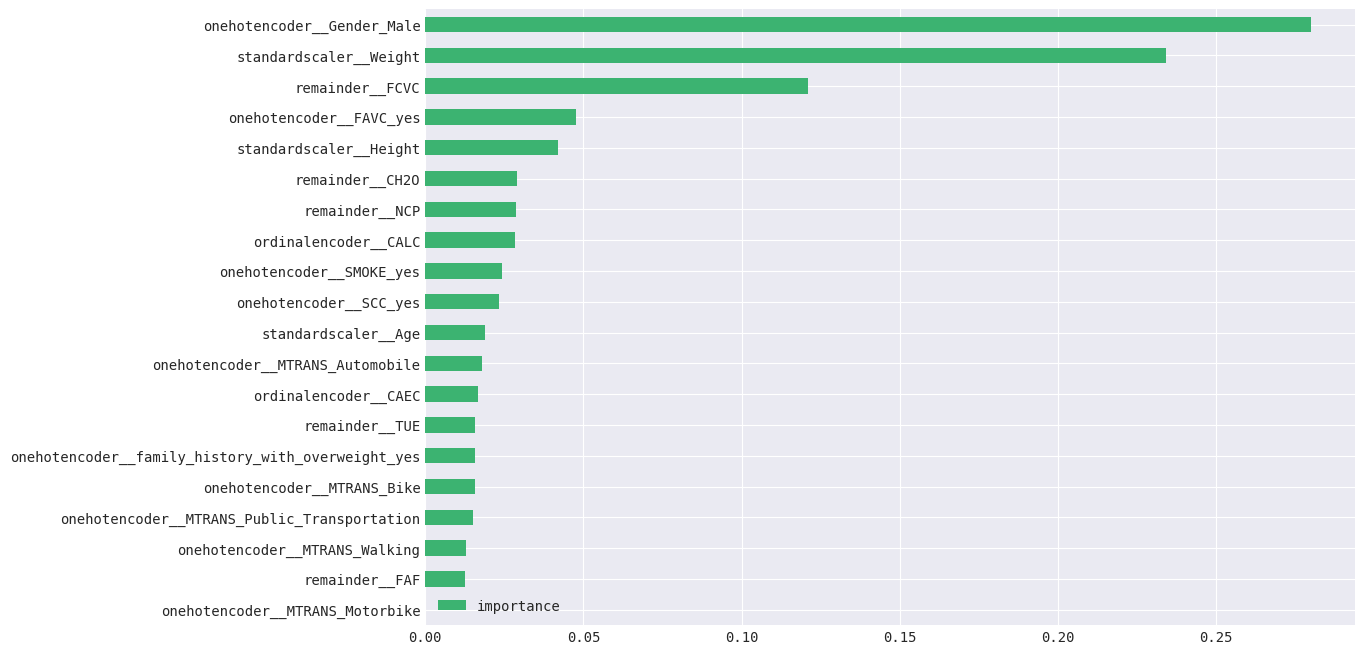

In [159]:
importance = xg_boost.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X_train_processed.columns, columns=['importance']).sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371');

In [160]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['BMI'] = df_copy['Weight'] / (df_copy['Height'] ** 2)
    
    df_copy['Age'], _  = boxcox(df_copy['Age'])
    
    df_copy['FCVC'] = pd.cut(df_copy['FCVC'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
    df_copy['NCP'] = pd.cut(df_copy['NCP'],
                              bins=[0.5,1.5,2.5,3.5,4.5],
                              labels=[1,2,3,4]).astype('float64')
    df_copy['CH2O'] = pd.cut(df_copy['CH2O'],
                              bins=[0.5,1.5,2.5,3.5],
                              labels=[1,2,3]).astype('float64')
    df_copy['FAF'] = pd.cut(df_copy['FAF'],
                              bins=[-0.5,0.5,1.5,2.5,3.5],
                              labels=[0,1,2,3]).astype('float64')
    df_copy['TUE'] = pd.cut(df_copy['TUE'],
                              bins=[-0.5,0.5,1.5,2.5],
                              labels=[0,1,2]).astype('float64')
    
    # Instantiate the PolynomialFeatures object with degree 3
    poly = PolynomialFeatures(degree=3, include_bias=False)

    # Select the columns you want to transform
    features = df_copy[['BMI', 'Weight']]

    # Fit and transform the features to generate polynomial features
    poly_features = poly.fit_transform(features)

    # Create a new DataFrame with the polynomial features
    poly_feature_names = poly.get_feature_names_out(['BMI', 'Weight'])
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    df_poly.drop(columns=['BMI','Weight'], inplace=True)

    # Optionally, concatenate the original DataFrame with the new polynomial features
    df_copy = pd.concat([df_copy, df_poly], axis=1)
    return df_copy

In [161]:
df1 = pd.read_csv('train.csv')
# drop id 
df1.drop(columns='id', inplace=True)
df_original1 = pd.read_csv('ObesityDataSet.csv')
# Combine 2 datasets
df1 = pd.concat([df1, df_original1], ignore_index=True)

In [162]:
df_trans = feature_engineering(df1)
df_trans

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,MTRANS,NObeyesdad,BMI,BMI^2,BMI Weight,Weight^2,BMI^3,BMI^2 Weight,BMI Weight^2,Weight^3
0,Male,0.675652,1.699998,81.669950,yes,yes,2.0,3.0,Sometimes,no,...,Public_Transportation,Overweight_Level_II,28.259565,798.603001,2307.957241,6669.980733,22568.173215,65221.867128,188490.752492,5.447370e+05
1,Female,0.672095,1.560000,57.000000,yes,yes,2.0,3.0,Frequently,no,...,Automobile,Normal_Weight,23.422091,548.594334,1335.059172,3249.000000,12849.226268,31269.877047,76098.372781,1.851930e+05
2,Female,0.672095,1.711460,50.165754,yes,yes,2.0,1.0,Sometimes,no,...,Public_Transportation,Insufficient_Weight,17.126706,293.324052,859.174110,2516.602874,5023.674734,14714.822210,43101.117041,1.262473e+05
3,Female,0.674060,1.710730,131.274851,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,44.855798,2012.042650,5888.438252,17233.086505,90251.779503,264130.599132,773003.854132,2.262271e+06
4,Male,0.677632,1.914186,93.798055,yes,yes,3.0,2.0,Sometimes,no,...,Public_Transportation,Overweight_Level_II,25.599151,655.316531,2401.150572,8798.075122,16775.546820,61467.416021,225223.253401,8.252423e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Female,0.674073,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,44.901475,2016.142457,5900.436735,17268.201231,90527.770141,264938.312544,775367.705886,2.269189e+06
22865,Female,0.674595,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,43.741923,1913.355859,5850.173562,17887.174802,83693.865312,255897.843533,782419.429196,2.392283e+06
22866,Female,0.674852,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,43.543817,1896.063963,5821.344623,17872.842838,82561.861424,253483.562526,778251.790383,2.389409e+06
22867,Female,0.675622,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,...,Public_Transportation,Obesity_Type_III,44.071535,1942.300233,5876.791210,17781.326666,85600.153474,258999.211858,783650.367678,2.371080e+06


In [163]:
# Split features and target label
y_trans = df_trans['NObeyesdad']
X_trans = df_trans.drop(columns='NObeyesdad')
# Encode target classes 
mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
inverse_mapping = {v: k for k, v in mapping.items()}
y_trans = y_trans.map(mapping)

# Split into train and test set
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_trans, test_size=0.2, shuffle=True, stratify=y_trans, random_state=RANDOM_STATE)
display(X_train_trans)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,MTRANS,BMI,BMI^2,BMI Weight,Weight^2,BMI^3,BMI^2 Weight,BMI Weight^2,Weight^3
19926,Female,0.673566,1.741192,128.763843,yes,yes,3.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,42.471794,1803.853267,5468.831387,16580.127264,76612.883977,232271.078885,704187.746057,2.134921e+06
15522,Male,0.677889,1.720000,83.000000,yes,yes,2.0,1.0,Sometimes,no,...,no,Walking,28.055706,787.122627,2328.623580,6889.000000,22083.280847,65331.178058,193275.757166,5.717870e+05
15970,Female,0.673566,1.735461,137.796884,yes,yes,3.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,45.751957,2093.241614,6304.477179,18987.981240,95769.901363,288442.171923,868737.310566,2.616485e+06
18897,Male,0.677938,1.858265,97.582959,yes,yes,2.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,28.259124,798.578066,2757.608899,9522.433887,22567.116264,77927.610676,269095.636088,9.292273e+05
11157,Female,0.672095,1.700000,50.000000,no,yes,2.0,4.0,Sometimes,no,...,Sometimes,Public_Transportation,17.301038,299.325918,865.051903,2500.000000,5178.649101,14966.295902,43252.595156,1.250000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,Female,0.673147,1.531610,62.877347,yes,no,2.0,1.0,Sometimes,no,...,no,Public_Transportation,26.803890,718.448505,1685.357476,3953.560766,19257.214504,45174.135943,105970.806822,2.485894e+05
21302,Female,0.673749,1.755978,53.699561,yes,yes,2.0,4.0,Frequently,no,...,no,Public_Transportation,17.415366,303.294957,935.197484,2883.642852,5281.992534,16286.806024,50219.694325,1.548504e+05
666,Female,0.676196,1.624950,111.886611,yes,yes,3.0,3.0,Sometimes,no,...,Sometimes,Public_Transportation,42.373869,1795.544736,4741.068547,12518.613721,76084.176630,200897.415426,530462.092282,1.400665e+06
4435,Male,0.677570,1.848294,121.310257,yes,yes,2.0,3.0,Sometimes,no,...,Sometimes,Automobile,35.510388,1260.987643,4307.774273,14716.178453,44778.160250,152970.735075,522577.204132,1.785223e+06


In [164]:
numerical_cols = [cname for cname in df_trans.columns if df_trans[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in df_trans.columns if df_trans[cname].dtype == "object" and cname != 'NObeyesdad']
# Printing numerical and categorical column lists
print('Numerical Columns: ', numerical_cols)
print('Categorical Columns: ', categorical_cols)

Numerical Columns:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'BMI^2', 'BMI Weight', 'Weight^2', 'BMI^3', 'BMI^2 Weight', 'BMI Weight^2', 'Weight^3']
Categorical Columns:  ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [165]:
numerical_cols.remove('FCVC')
numerical_cols.remove('NCP')
numerical_cols.remove('CH2O')
numerical_cols.remove('FAF')
numerical_cols.remove('TUE')
numerical_cols

['Age',
 'Height',
 'Weight',
 'BMI',
 'BMI^2',
 'BMI Weight',
 'Weight^2',
 'BMI^3',
 'BMI^2 Weight',
 'BMI Weight^2',
 'Weight^3']

In [166]:
# data preprocessing, why not drop 1 col in 1-hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
oe = OrdinalEncoder(categories = [['no', 'Sometimes', 'Frequently', 'Always']] * 2)
scaler = StandardScaler()
col_trans = make_column_transformer(
    (ohe, ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    (oe, ['CAEC', 'CALC']),
    (scaler, numerical_cols),
    remainder='passthrough',
    n_jobs=-1
)
col_trans.set_output(transform='pandas')

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always']]),
                                 ['CAEC', 'CALC']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Height', 'Weight', 'BMI', 'BMI^2',
                                  'BMI Weight', 'Weight^2', 'BMI^3',
                                  'BMI^2 Weight', 'BMI Weight^2',
                                  'Weight^3'])])

In [167]:
# Preprocess train and test sets
X_train_trans = col_trans.fit_transform(X_train_trans)
X_test_trans = col_trans.transform(X_test_trans)
display(X_train_trans)

,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_yes,onehotencoder__FAVC_yes,onehotencoder__SMOKE_yes,onehotencoder__SCC_yes,onehotencoder__MTRANS_Automobile,onehotencoder__MTRANS_Bike,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,...,standardscaler__Weight^2,standardscaler__BMI^3,standardscaler__BMI^2 Weight,standardscaler__BMI Weight^2,standardscaler__Weight^3,remainder__FCVC,remainder__NCP,remainder__CH2O,remainder__FAF,remainder__TUE
19926,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.722520,1.708461,1.812047,1.854358,1.837998,3.0,3.0,2.0,0.0,1.0
15522,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.316306,-0.468062,-0.449857,-0.432030,-0.415960,2.0,1.0,2.0,1.0,0.0
15970,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.229086,2.473104,2.573121,2.590735,2.532387,3.0,3.0,2.0,2.0,1.0
18897,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.237717,-0.448750,-0.279185,-0.092727,0.099451,2.0,3.0,3.0,1.0,1.0
11157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.239667,-1.142803,-1.132261,-1.103400,-1.060203,2.0,4.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.933866,-0.580863,-0.722969,-0.822729,-0.881994,2.0,1.0,1.0,2.0,1.0
21302,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.158956,-1.138678,-1.114369,-1.072221,-1.017160,2.0,4.0,2.0,3.0,2.0
666,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.868056,1.687358,1.386958,1.076916,0.779239,3.0,3.0,3.0,0.0,0.0
4435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.330381,0.437793,0.737590,1.041631,1.333752,2.0,3.0,1.0,1.0,0.0


In [168]:
param_grid = [{
        'C': [1e-1, 1, 10, 100, 1000],
        'penalty': ['l2']
    },
{
    'penalty': [None]
}]
logreg_feateng = hyper_search(LogisticRegression(max_iter=10000, random_state=RANDOM_STATE), 'logistic_regression_feateng', param_grid, X_train_trans, y_train_trans)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
5,{'penalty': None},7.715901,0.003378,0.874283,0.876592
4,"{'penalty': 'l2', 'C': 1000}",10.240055,0.004656,0.873955,0.876469
3,"{'penalty': 'l2', 'C': 100}",9.587310,0.006820,0.873572,0.876442
2,"{'penalty': 'l2', 'C': 10}",8.090068,0.007660,0.872971,0.875594
1,"{'penalty': 'l2', 'C': 1}",5.633637,0.009328,0.871386,0.873613
0,"{'penalty': 'l2', 'C': 0.1}",3.654758,0.006958,0.865920,0.867436


# 6. EVALUATION

In [169]:
import joblib

# Load KNN model đã lưu
knn_loaded = joblib.load('checkpoint/KNN.joblib')

# Dự đoán trên tập test
y_pred_knn = knn_loaded.predict(X_test_processed)

model_name = 'knn (loaded)'
print(f'Accuracy of {model_name}', accuracy_score(y_test, y_pred_knn))
print(f'F1_score of {model_name}', f1_score(y_test, y_pred_knn, average='weighted'))
print(f'Precision_score of {model_name}', precision_score(y_test, y_pred_knn, average='weighted'))
print(f'Recall_score of {model_name}', recall_score(y_test, y_pred_knn, average='weighted'))

Accuracy of knn (loaded) 0.8384766907419566
F1_score of knn (loaded) 0.8365649890007838
Precision_score of knn (loaded) 0.8363348981104022
Recall_score of knn (loaded) 0.8384766907419566


In [170]:

# Logistic Regression
logreg_loaded = joblib.load('checkpoint/logistic_regression.joblib')
y_pred_logreg = logreg_loaded.predict(X_test_processed)
print('Logistic Regression:', accuracy_score(y_test, y_pred_logreg))

# Random Forest
rf_loaded = joblib.load('checkpoint/random_forest.joblib')
y_pred_rf = rf_loaded.predict(X_test_processed)
print('Random Forest:', accuracy_score(y_test, y_pred_rf))

# Decision Tree
dt_loaded = joblib.load('checkpoint/decision_tree.joblib')
y_pred_dt = dt_loaded.predict(X_test_processed)
print('Decision Tree:', accuracy_score(y_test, y_pred_dt))

# XGBoost
xgb_loaded = joblib.load('checkpoint/xg_boost.joblib')
y_pred_xgb = xgb_loaded.predict(X_test_processed)
print('XGBoost:', accuracy_score(y_test, y_pred_xgb))

logregFeateng_loaded = joblib.load('checkpoint/logistic_regression_feateng.joblib')
y_pred_logregFeateng = logregFeateng_loaded.predict(X_test_trans)  # Đúng là X_test_trans
print('Logistic Regression with feature engineering:', accuracy_score(y_test_trans, y_pred_logregFeateng))

Logistic Regression: 0.8653972422849638
Random Forest: 0.9026045086452178
Decision Tree: 0.8824688115561392
XGBoost: 0.908513898008317
Logistic Regression with feature engineering: 0.8734149540883254


In [171]:
y_pred = votingClf.predict(X_test_processed)
model_name = 'Voting Classifier'
print(f'Accuracy of {model_name}', accuracy_score(y_test, y_pred))
print(f'F1_score of {model_name}', f1_score(y_test, y_pred, average='weighted'))
print(f'Precision_score of {model_name}', precision_score(y_test, y_pred, average='weighted'))
print(f'Recall_score of {model_name}', recall_score(y_test, y_pred, average='weighted'))

Accuracy of Voting Classifier 0.9115780258262202
F1_score of Voting Classifier 0.9111242954014158
Precision_score of Voting Classifier 0.9111559821540853
Recall_score of Voting Classifier 0.9115780258262202


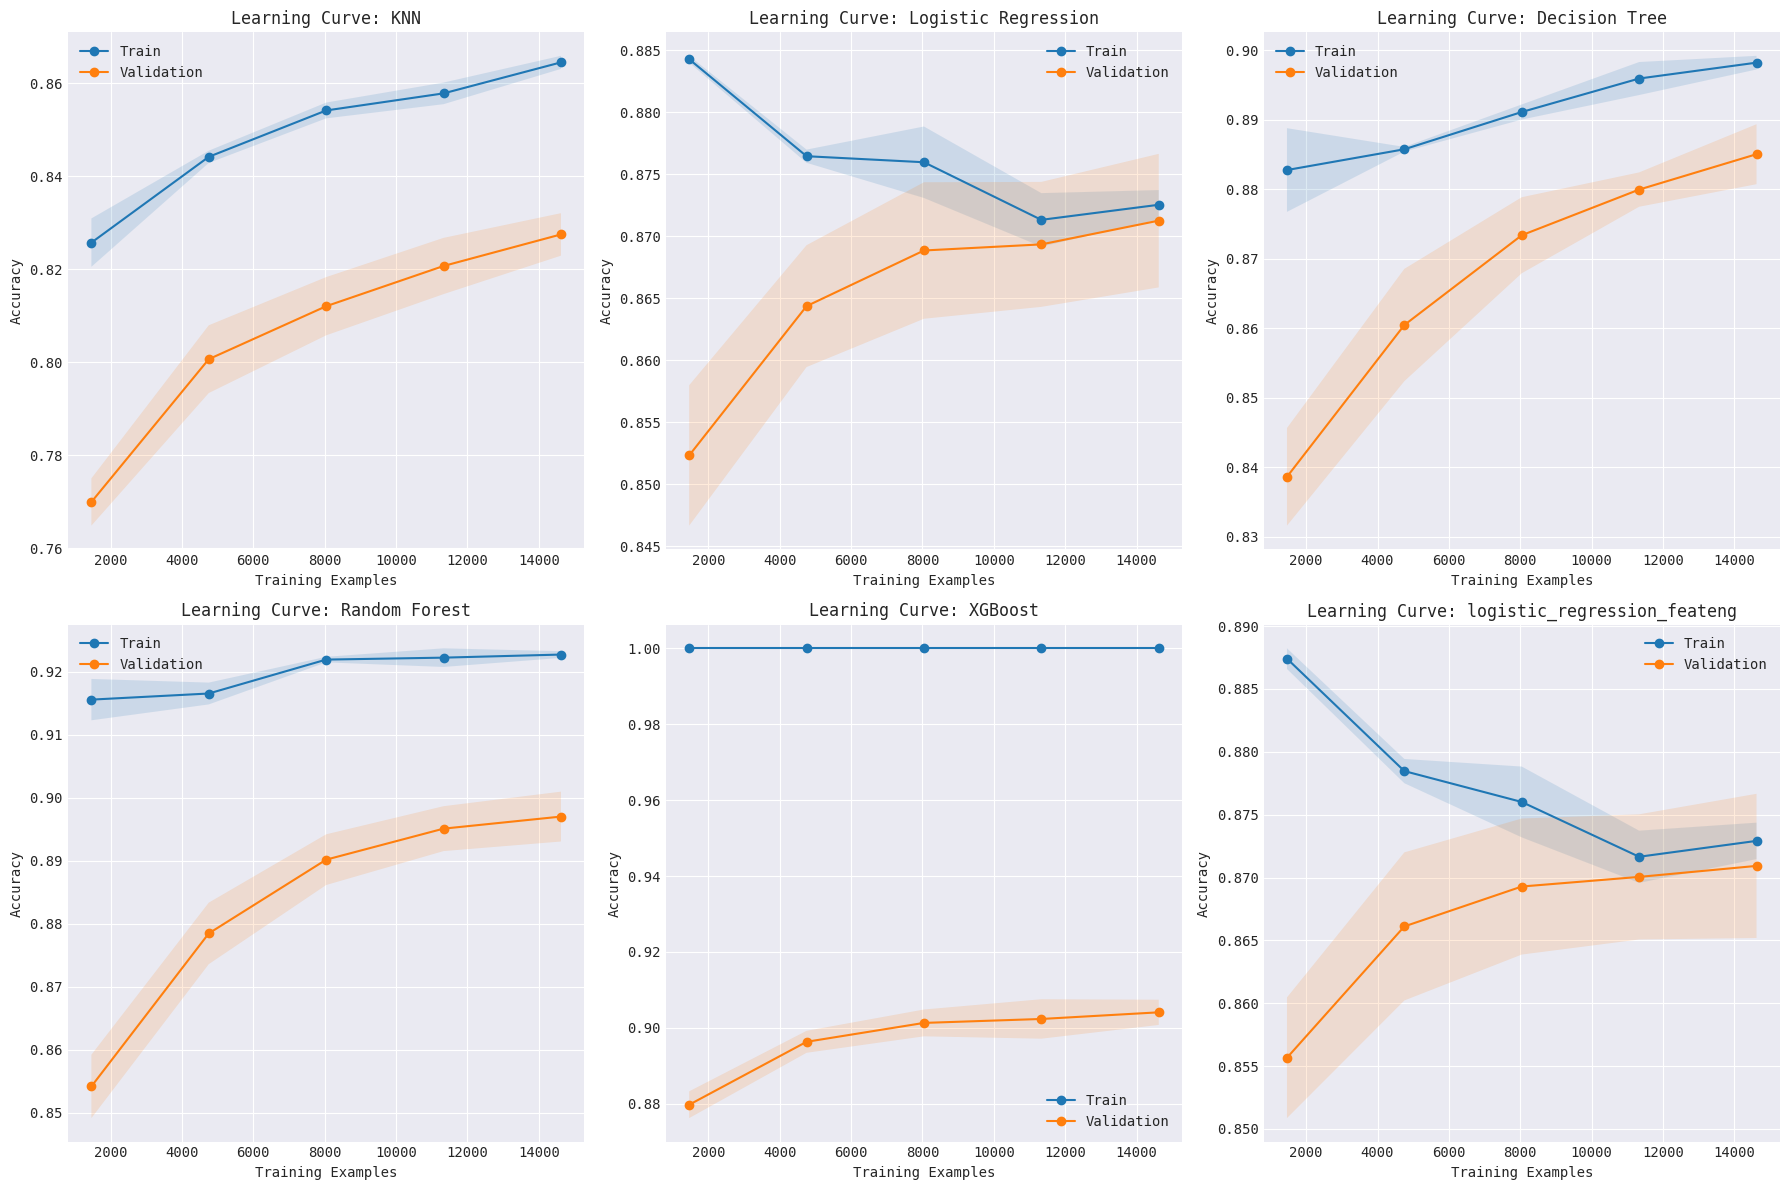

In [172]:
from sklearn.model_selection import learning_curve

models = {
    'KNN': joblib.load('checkpoint/KNN.joblib'),
    'Logistic Regression': joblib.load('checkpoint/logistic_regression.joblib'),
    'Decision Tree': joblib.load('checkpoint/decision_tree.joblib'),
    'Random Forest': joblib.load('checkpoint/random_forest.joblib'),
    'XGBoost': joblib.load('checkpoint/xg_boost.joblib'),
    'logistic_regression_feateng': joblib.load('checkpoint/logistic_regression_feateng.joblib'),
}

plt.figure(figsize=(18, 12))
for i, (name, model) in enumerate(models.items(), 1):
    if model_name == 'logistic_regression_feateng':
        plt.subplot(2, 3, i)
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train_trans, y_train_trans, cv=5, scoring='accuracy', n_jobs=-1)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        plt.plot(train_sizes, train_mean, label='Train', marker='o')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
        plt.plot(train_sizes, test_mean, label='Validation', marker='o')
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
        plt.title(f'Learning Curve: {name}')
        plt.xlabel('Training Examples')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(2, 3, i)
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train_processed, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        plt.plot(train_sizes, train_mean, label='Train', marker='o')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
        plt.plot(train_sizes, test_mean, label='Validation', marker='o')
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
        plt.title(f'Learning Curve: {name}')
        plt.xlabel('Training Examples')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
plt.tight_layout()
plt.show()

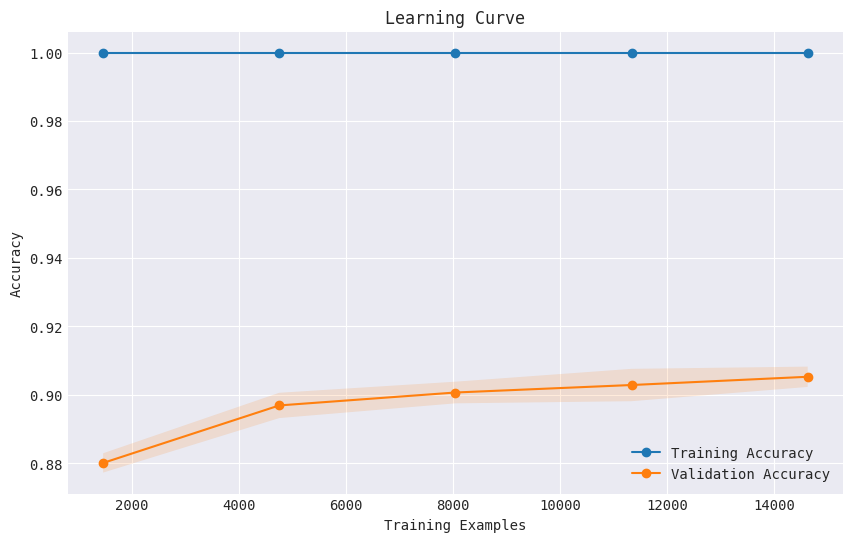

In [173]:
#Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(votingClf, X_train_processed, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o', linestyle='-')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o', linestyle='-')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)

plt.show()

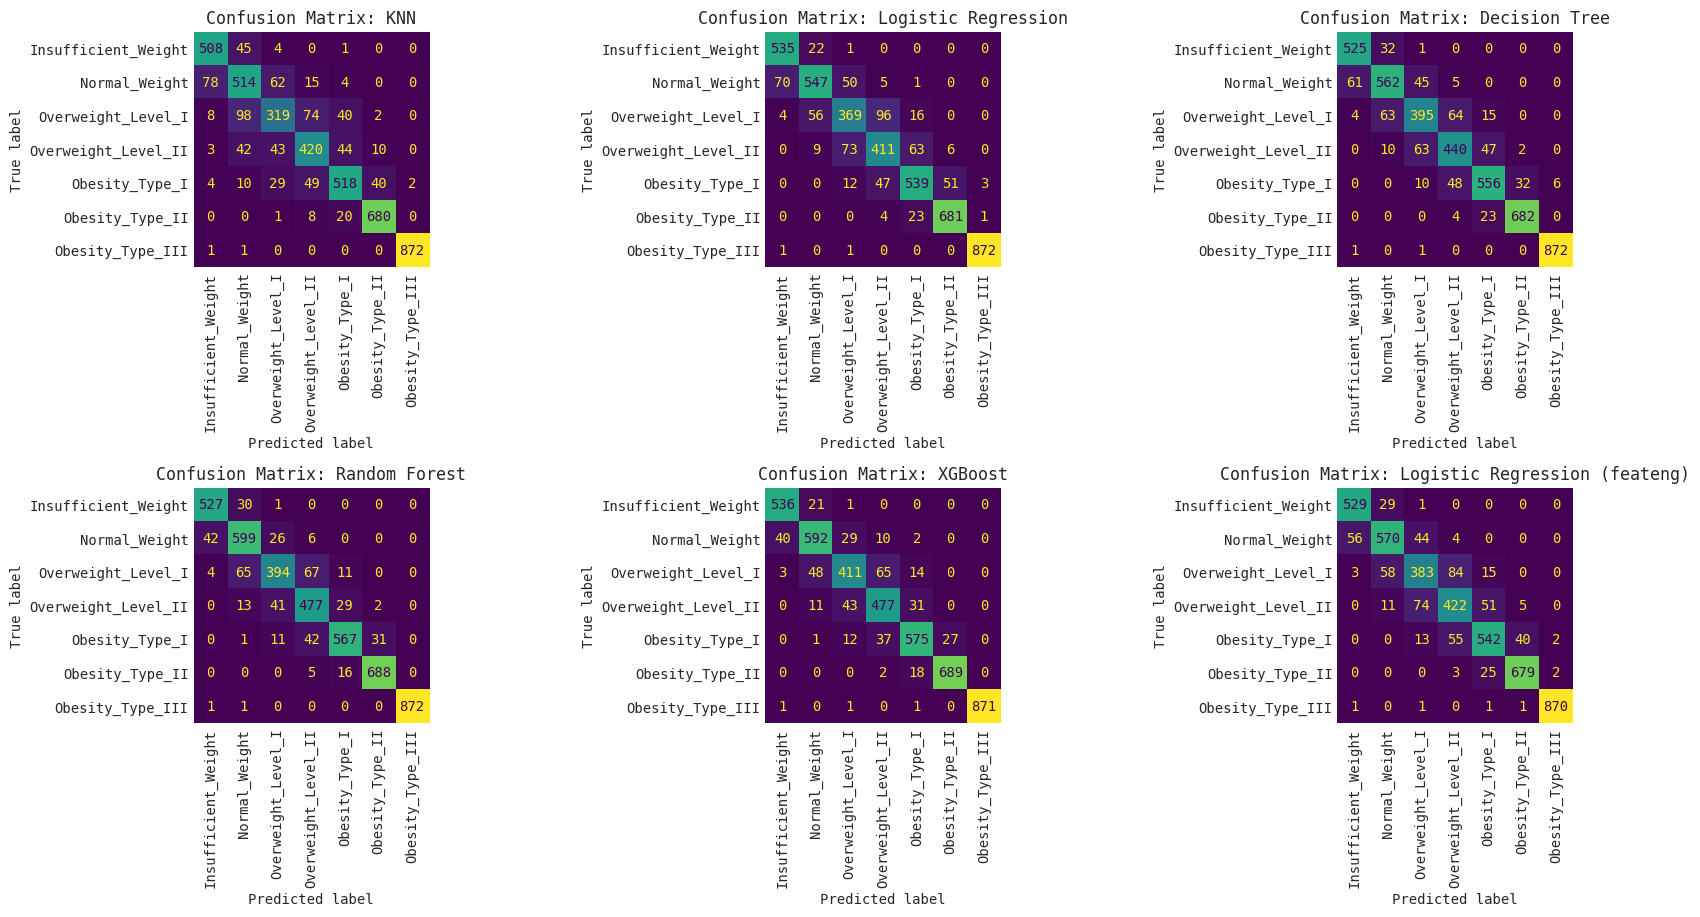

In [174]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.close('all')  # Đóng tất cả figure cũ

target_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

models_preds = {
    'KNN': (y_test, y_pred_knn),
    'Logistic Regression': (y_test, y_pred_logreg),
    'Decision Tree': (y_test, y_pred_dt),
    'Random Forest': (y_test, y_pred_rf),
    'XGBoost': (y_test, y_pred_xgb),
    'Logistic Regression (feateng)': (y_test_trans, y_pred_logregFeateng)
}

plt.figure(figsize=(18, 12))
for i, (name, (y_true, y_pred_)) in enumerate(models_preds.items(), 1):
    ax = plt.subplot(3, 3, i)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred_, ax=ax, colorbar=False)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xticklabels(target_names, rotation=90)
    ax.set_yticklabels(target_names)
    ax.grid(False)
plt.tight_layout()
plt.show()

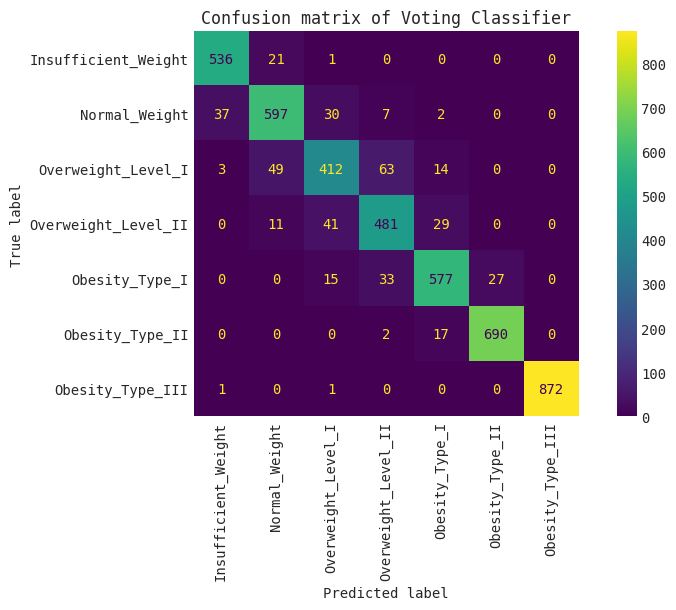

In [175]:
target_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(target_names, rotation=90)  
ax.yaxis.set_ticklabels(target_names)
ax.grid(False)  
_ = ax.set_title("Confusion matrix of Voting Classifier")
plt.show()

In [176]:
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.94       558
      Normal_Weight       0.88      0.89      0.88       673
 Overweight_Level_I       0.82      0.76      0.79       541
Overweight_Level_II       0.82      0.86      0.84       562
     Obesity_Type_I       0.90      0.88      0.89       652
    Obesity_Type_II       0.96      0.97      0.97       709
   Obesity_Type_III       1.00      1.00      1.00       874

           accuracy                           0.91      4569
          macro avg       0.90      0.90      0.90      4569
       weighted avg       0.91      0.91      0.91      4569



In [177]:
df_results

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_name
0,"{'p': 1, 'n_neighbors': 9}",0.008529,1.632976,0.827479,0.864467,KNN
1,"{'penalty': 'l2', 'C': 10}",5.769829,0.007664,0.870924,0.872483,logistic_regression
2,"{'min_samples_leaf': 20, 'max_depth': 10, 'cri...",0.134986,0.003911,0.885040,0.898213,decision_tree
3,"{'n_estimators': 500, 'min_samples_leaf': 10, ...",14.471641,0.286352,0.897078,0.922672,random_forest
4,"{'n_estimators': 300, 'max_depth': 20}",13.158921,0.555838,0.905012,1.000000,xg_boost
5,"XGBClassifier, RandomForestClassifier",18.570783,0.584493,0.905286,1.000000,voting_classifier
6,{'penalty': None},7.715901,0.003378,0.874283,0.876592,logistic_regression_feateng


In [178]:
df_results.to_csv('result_report_new.csv')